In [1]:
#-*- encoding: utf-8 -*-
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from torch.optim.optimizer import Optimizer
from torch.optim import Adam,lr_scheduler,AdamW
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 

import pandas as pd
import numpy as np
import sys, gc, os, glob

# 학과 DGX CORE GPU 5인 경우 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
train_files = sorted(glob.glob('./train/*.npy'))
test_files = sorted(glob.glob('./test/*.npy'))

In [3]:
train_df = pd.DataFrame(train_files, columns = ['id'])
test_df = pd.DataFrame(test_files, columns = ['id'])

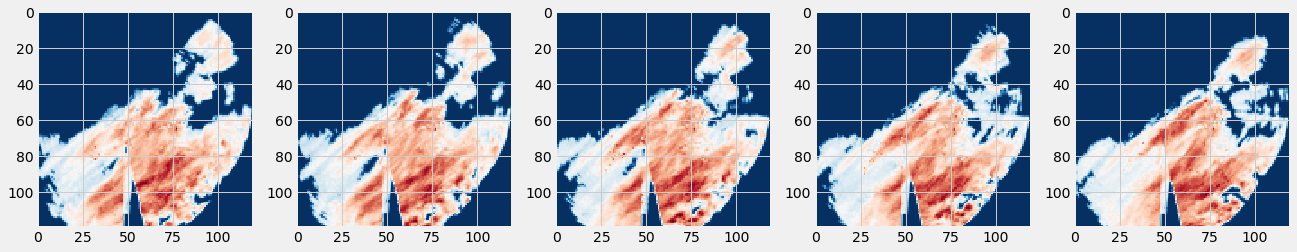

In [4]:
import matplotlib.pylab as plt

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[56]).flatten().reshape(120, 120, 5)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CloudTrainDataset(Dataset):
    """ Cloud Dataset """ 
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        transform = transforms.Compose([
                transforms.ToTensor()
                ])
        image = np.load(self.data.loc[idx, 'id'])
        
        target = image[:, :, -1]
        image = image[:, :, 0:4]

            
        return transform(image), transform(target) 

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CloudTestDataset(Dataset):
    """ Cloud Dataset """ 
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        transform = transforms.Compose([
                transforms.ToTensor()
                ])
        image = np.load(self.data.loc[idx, 'id'])
        return transform(image)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            return cbr

        # Contracting path 
        # padding을 넣어서 output size가 바뀌지 않도록 설정했음 
        self.pad = nn.ZeroPad2d(4) 
        self.enc1_1 = CBR2d(in_channels=4, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)     
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.ppm1 = PPM(64, 64//4, (1, 2, 3, 6))

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.ppm2 = PPM(128, 128//4, (1, 2, 3, 6))
 
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2)    
        self.ppm3 = PPM(256, 256//4, (1, 2, 3, 6))

        self.enc4_1 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc4_2 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2)    
        self.ppm4 = PPM(256, 256//4, (1, 2, 3, 6))

        self.enc5_1 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)

        # Expansive path 
        self.dec5_1 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.unpool4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        ## Encoder와 Decoder 파트의 인덱스를 동일하게 하기 위해서, 순서를 거꾸로 매겨줌 
        ### self.enc4_2의 output channel -> input channel / input channel -> output channel으로 매겨짐 
        ### 512인 이유는 self.enc4_2의 output channel + self.unpool4의 output channel 
        self.dec4_2 = CBR2d(in_channels=256*4, out_channels=256) 
        self.dec4_1 = CBR2d(in_channels=256, out_channels=256) 

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        
        self.dec3_2 = CBR2d(in_channels=256*4, out_channels=256) 
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128) 

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=128*4, out_channels=128) 
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64) 

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=64*4, out_channels=64) 
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True) # Output Segmentation map 

        self._initialize_weights()

    def forward(self, x):
        x = self.pad(x)
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        ppm1 = self.ppm1(enc1_2)


        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        ppm2 = self.ppm2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        ppm3 = self.ppm3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        ppm4 = self.ppm4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)
        unpool4 = self.unpool4(dec5_1)

        cat4 = torch.cat((unpool4, enc4_2, ppm4), dim=1) # torch.cat의 dim : [0: batch, 1:channel, 2:height, 3:width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        unpool3 = self.unpool3(dec4_1)

        cat3 = torch.cat((unpool3, enc3_2, ppm3), dim=1) 
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        unpool2 = self.unpool2(dec3_1)

        cat2 = torch.cat((unpool2, enc2_2, ppm2), dim=1) 
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        unpool1 = self.unpool1(dec2_1)

        cat1 = torch.cat((unpool1, enc1_2, ppm1), dim=1) 
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1) 
        x = x[:,:,4:4+120, 4:4+120]      
        return torch.sigmoid(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

In [9]:
if __name__ == '__main__':
    cloud_model = UNet()
    input = torch.rand(32, 4, 120, 120)
    output = cloud_model(input)
    print(output.size(), '\n')

torch.Size([32, 1, 120, 120]) 



In [10]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [12]:
import time 
from tqdm.notebook import tqdm

criterion = nn.L1Loss(reduction = 'sum')
kf = KFold(5, shuffle=True, random_state=0)
dev = torch.cuda.set_device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_name = 'UNet'
nb_epochs = 35
valid_preds = []

for i, (tr_idx, val_idx) in enumerate(kf.split(range(0, train_df.shape[0]))):
    print("==" * 20, "{} Fold Start".format(i), "=="*20)
    start_time = time.time()
    best_valid = 0
    valid_pred = []
    
    x_trainset = train_df.loc[tr_idx].reset_index(drop=True)
    x_validset = train_df.loc[val_idx].reset_index(drop=True)
    
    train_loader = DataLoader(CloudTrainDataset(data = x_trainset), batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    valid_loader = DataLoader(CloudTrainDataset(data = x_validset), batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
    model = UNet().cuda()

    optimizer = Adam(model.parameters(), lr=0.025)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, eta_min=1e-6) # 1e-6
    
    train_loss_list, valid_loss_list = [], []
    for epoch in (range(0, nb_epochs)):
        # train 학습
        train_loss, valid_loss = 0, 0

        model.train()
        for idx, (x_train, y_train) in enumerate(train_loader):
            x_train, y_train = x_train.to(dev), y_train.to(dev)
            optimizer.zero_grad()
            prediction = model(x_train.cuda().float())
            loss = criterion(prediction, y_train.cuda().float())
            loss.backward()
            train_loss += (255 * loss.item() / (len(train_loader.dataset) * 120 * 120))
            optimizer.step()
        
        # valid 검증 
        model.eval()
        with torch.no_grad():
            for idx, (x_valid, y_valid) in enumerate(valid_loader):
                x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
                prediction = model(x_valid.cuda().float())
                loss = criterion(prediction, y_valid.cuda().float())    
                valid_loss += (255 * loss.item() / (len(valid_loader.dataset) * 120 * 120))
        
        end_time = time.time()
        if epoch % 1 == 0: 
            print('Epoch {:4d}/{} Time {:4f} Train Loss: {:.3f}  Valid Loss: {:.3f} '.format(epoch+1, nb_epochs, end_time - start_time, train_loss, valid_loss))

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        if (best_valid == 0 or (best_valid > valid_loss)):
            best_valid = valid_loss
            # Background 제외한 버전 
            torch.save(model.state_dict(), './savedmodel/{}_FOLD_PYRAMID{}.pth'.format(model_name, i))
        
        scheduler.step()
    valid_preds.append(best_valid)

======================================== 2 Fold Start ========================================
Epoch    1/35 Time 645.874616 Train Loss: 4.811  Valid Loss: 3.614 
Epoch    2/35 Time 1282.927013 Train Loss: 3.557  Valid Loss: 3.927 
Epoch    3/35 Time 1920.530891 Train Loss: 3.343  Valid Loss: 3.286 
Epoch    4/35 Time 2558.626215 Train Loss: 3.189  Valid Loss: 3.663 
Epoch    5/35 Time 3196.606741 Train Loss: 3.071  Valid Loss: 3.212 
Epoch    6/35 Time 3835.179116 Train Loss: 3.009  Valid Loss: 3.004 
Epoch    7/35 Time 4473.524367 Train Loss: 2.963  Valid Loss: 2.977 
Epoch    8/35 Time 5112.021213 Train Loss: 2.919  Valid Loss: 3.014 
Epoch    9/35 Time 5750.121625 Train Loss: 2.889  Valid Loss: 2.875 
Epoch   10/35 Time 6389.686716 Train Loss: 2.870  Valid Loss: 2.846 
Epoch   11/35 Time 7029.826825 Train Loss: 3.000  Valid Loss: 3.442 
Epoch   12/35 Time 7669.959724 Train Loss: 2.924  Valid Loss: 3.088 
Epoch   13/35 Time 8314.907299 Train Loss: 2.906  Valid Loss: 2.990 
Epoch   1

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Epoch   10/35 Time 6444.678546 Train Loss: 2.850  Valid Loss: 2.835 
Epoch   11/35 Time 7089.456425 Train Loss: 2.998  Valid Loss: 3.502 
Epoch   12/35 Time 7729.521906 Train Loss: 2.919  Valid Loss: 3.084 
Epoch   13/35 Time 8369.025497 Train Loss: 2.881  Valid Loss: 3.276 
Epoch   14/35 Time 9008.763854 Train Loss: 2.859  Valid Loss: 2.947 
Epoch   15/35 Time 9647.998919 Train Loss: 2.841  Valid Loss: 3.060 
Epoch   16/35 Time 10286.864109 Train Loss: 2.837  Valid Loss: 2.995 
Epoch   17/35 Time 10924.857408 Train Loss: 2.813  Valid Loss: 2.895 
Epoch   18/35 Time 11562.287266 Train Loss: 2.801  Valid Loss: 2.812 
Epoch   19/35 Time 12200.105007 Train Loss: 2.782  Valid Loss: 3.078 
Epoch   20/35 Time 12837.681687 Train Loss: 2.772  Valid Loss: 2.916 
Epoch   21/35 Time 13475.185070 Train Loss: 2.763  Valid Loss: 2.809 
Epoch   22/35 Time 14112.816811 Train Loss: 2.743  Valid Loss: 2.866 
Epoch   23/35 Time 14750.091987 Train Loss: 2.732  Valid Loss: 2.835 
Epoch   24/35 Time 15387.4

In [13]:
print(valid_preds, '\n')
print(np.mean(valid_preds))

[2.703479302912196, 2.7020409113757613, 2.7169428377943734] 

2.7074876840274436


In [14]:
root_path = './'

In [17]:
# TTA를 적용하지 않은 정답지 
import gc
total_preds = []
total_answer = []

test_preds = []
for fold, (tr_idx, val_idx) in tqdm(enumerate(kf.split(range(0, train_df.shape[0])))):
    val_file = train_df.loc[val_idx].reset_index(drop=True)
    
    valid_loader = DataLoader(CloudTrainDataset(data = val_file), batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
    test_loader = DataLoader(CloudTestDataset(data = test_df), batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
    
    best_model = UNet().cuda()
    best_model.load_state_dict(torch.load('./savedmodel/{}_FOLD_PYRAMID{}.pth'.format(model_name, fold)))
    best_model.eval()
    
    valid_pred = []
    valid_ans = []
    with torch.no_grad():
        for idx, (x_valid, y_valid) in enumerate(valid_loader):
            x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
            prediction = best_model(x_valid.cuda().float())
            valid_pred.append(prediction.cpu().numpy().reshape(-1,14400))
            valid_ans.append(y_valid.cpu().numpy().reshape(-1,14400))
        total_preds.append(valid_pred)
        total_answer.append(valid_ans)
            
    test_pred = []
    best_model.eval()
    with torch.no_grad():
        for idx, x_test in enumerate(test_loader):
            x_test = x_test.to(dev)             
            prediction = best_model(x_test.cuda().float())
            test_pred.append(prediction.cpu().numpy().reshape(-1,14400))
    test_preds.append(test_pred)

In [18]:
from sklearn.metrics import mean_absolute_error
def loss(final_X_answers, final_X_pred):
    pred = final_X_pred
    answer = final_X_answers
    mae = mean_absolute_error(answer, pred) * 255
    return mae

In [19]:
final_val = np.array(total_preds).reshape(-1, 14400)
final_answer = np.array(total_answer).reshape(-1, 14400)
loss(final_answer, final_val)

2.7063259296119213

In [20]:
sub = pd.read_csv("sample_submission.csv")
sub.head()

file_name  0  1  2  3  4  5  6  7  8  ...  14390  14391  14392  14393  \
0  test_00000.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
1  test_00001.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
2  test_00002.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
3  test_00003.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
4  test_00004.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   

   14394  14395  14396  14397  14398  14399  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      0      0      0      0      0      0  
4      0      0      0      0      0      0  

[5 rows x 14401 columns]

In [21]:
sub.shape

(2674, 14401)

In [22]:
test_df['id'].values[0:15]

array(['./test/test_00000.npy', './test/test_00001.npy',
       './test/test_00002.npy', './test/test_00003.npy',
       './test/test_00004.npy', './test/test_00005.npy',
       './test/test_00006.npy', './test/test_00007.npy',
       './test/test_00008.npy', './test/test_00009.npy',
       './test/test_00010.npy', './test/test_00011.npy',
       './test/test_00012.npy', './test/test_00013.npy',
       './test/test_00014.npy'], dtype=object)

In [23]:
final_solution = np.reshape(np.mean(np.array(test_preds), axis=0), (-1, 14400))
final_solution = (final_solution * 255).astype(int)
submission = pd.concat([test_df, pd.DataFrame(final_solution)], axis=1)
submission.columns = np.append(['file_name'], [c for c in range(0, 14400)])
submission['file_name'] = sub['file_name'].values
submission.to_csv("cloud_v3(pyramid).csv", index=False)

In [24]:
submission.head()

file_name  0  1  2  3  4  5  6  7  8  ...  14390  14391  14392  14393  \
0  test_00000.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
1  test_00001.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
2  test_00002.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
3  test_00003.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
4  test_00004.npy  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   

   14394  14395  14396  14397  14398  14399  
0      0      0      0      0      0      0  
1      0      0      0      0      0      0  
2      0      0      0      0      0      0  
3      0      0      0      0      0      0  
4      0      0      0      0      0      0  

[5 rows x 14401 columns]

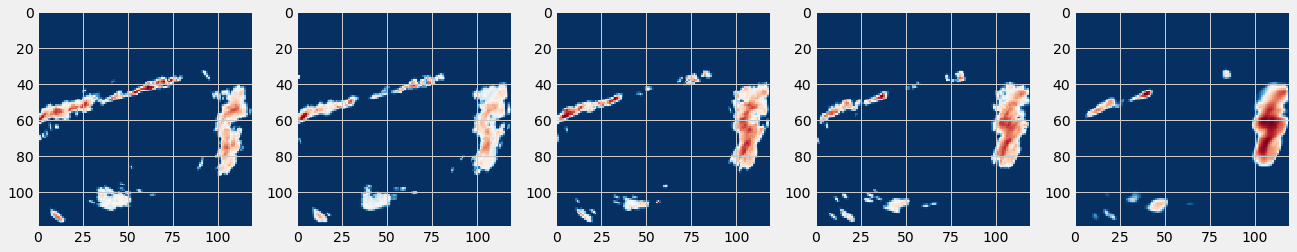

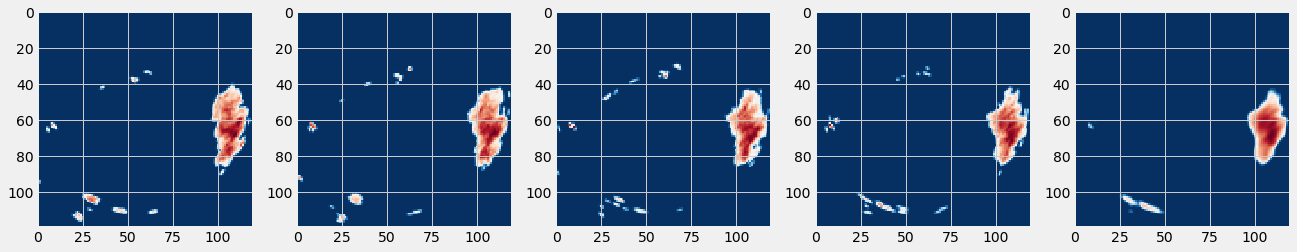

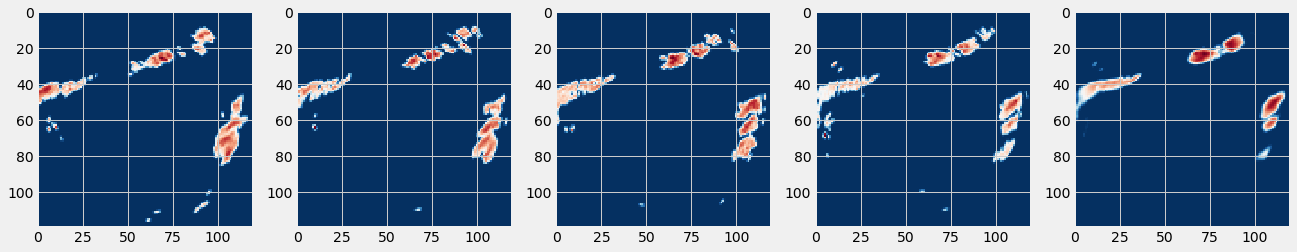

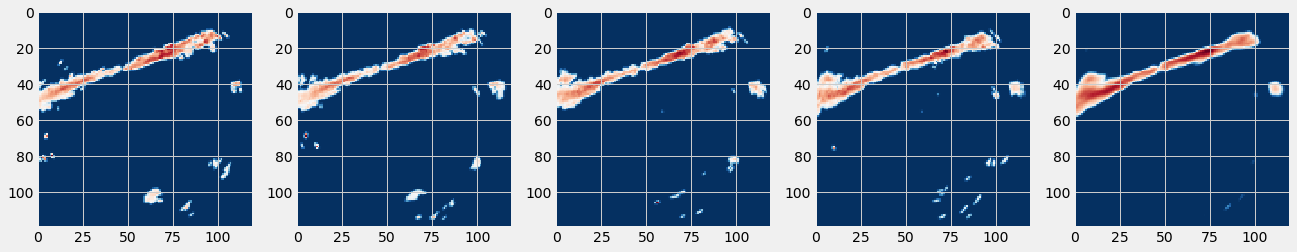

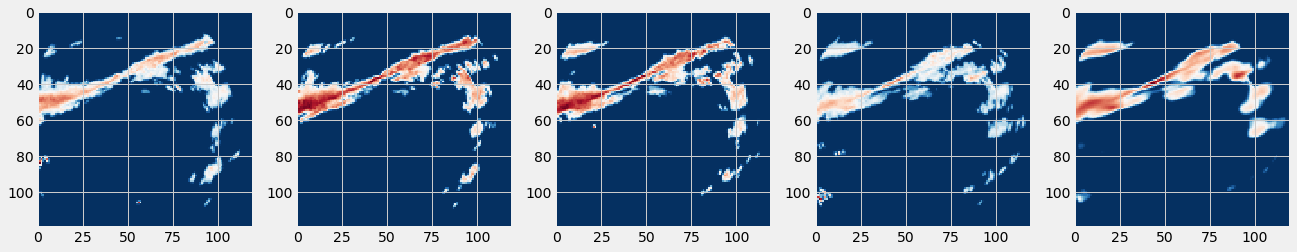

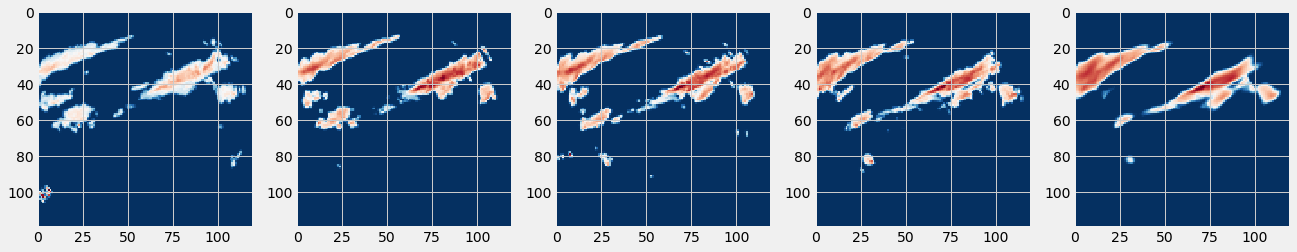

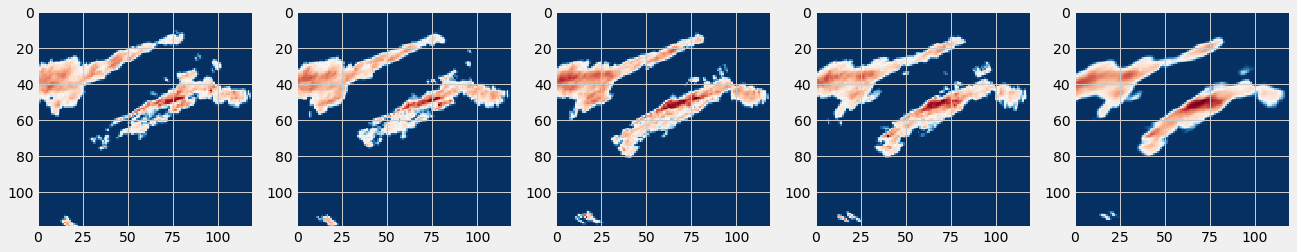

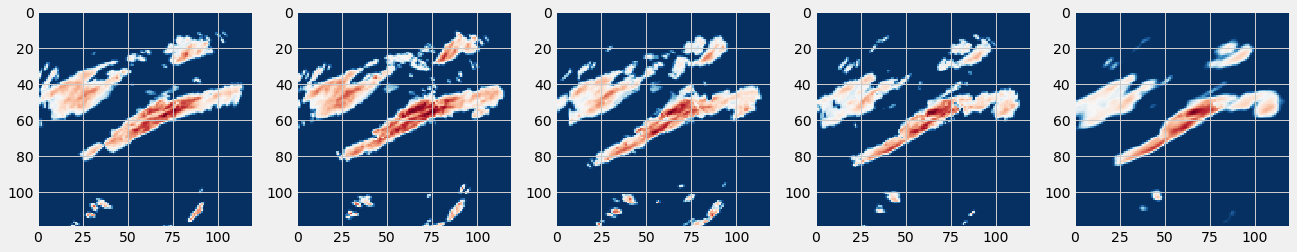

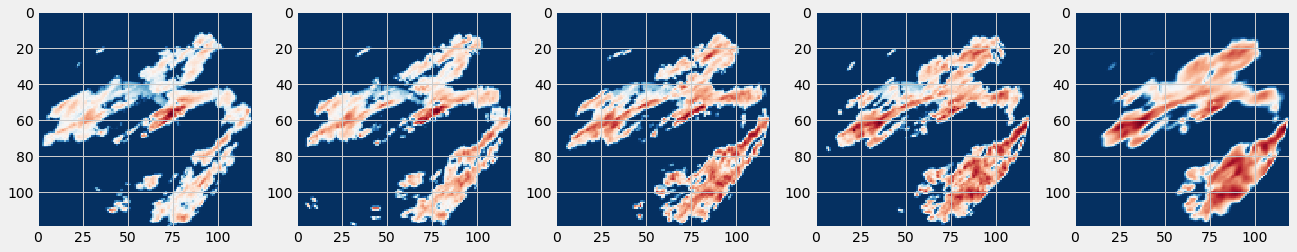

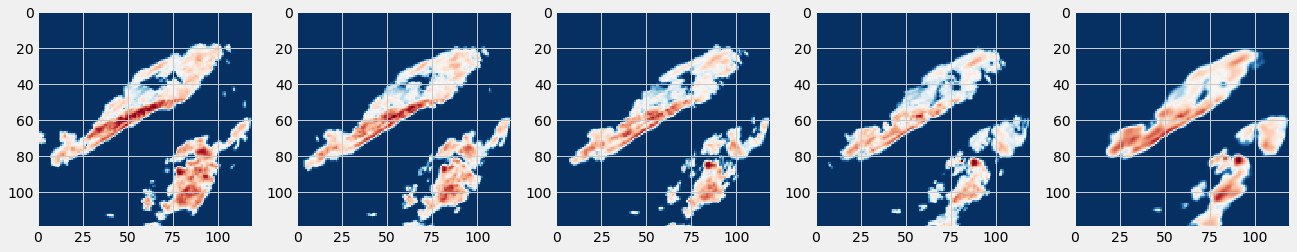

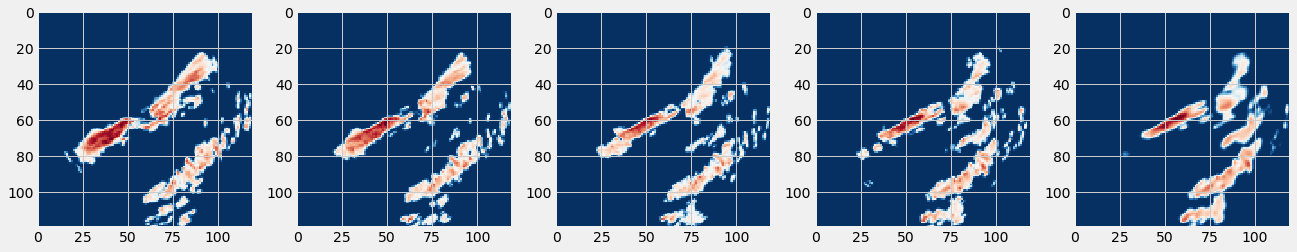

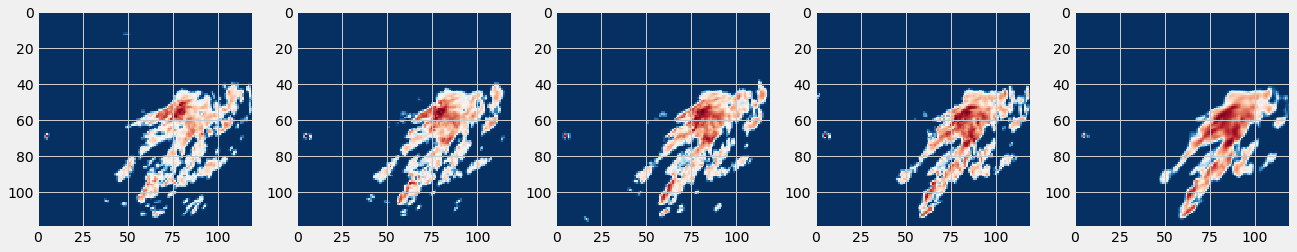

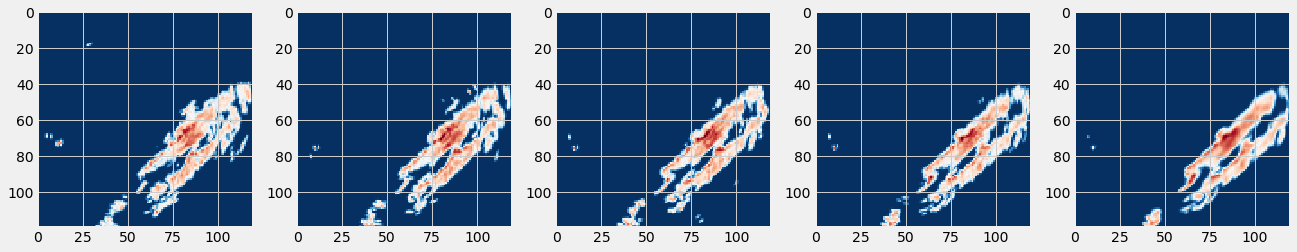

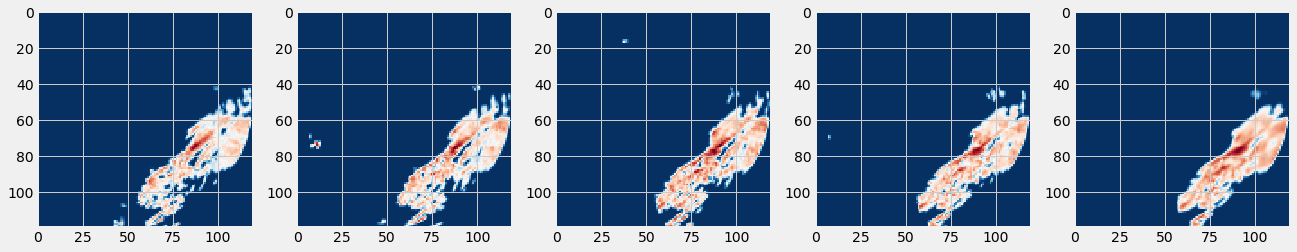

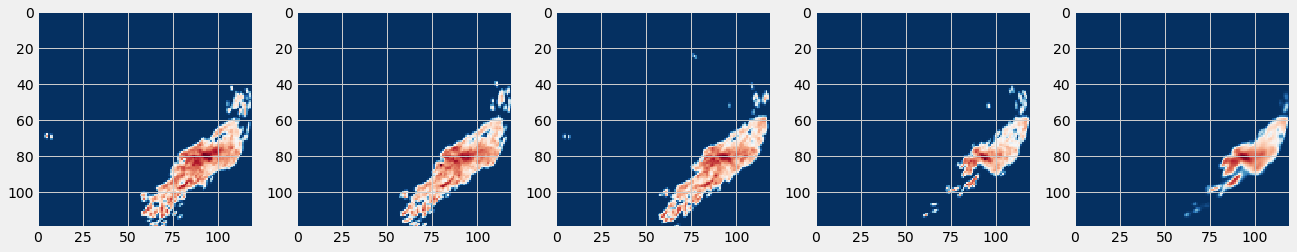

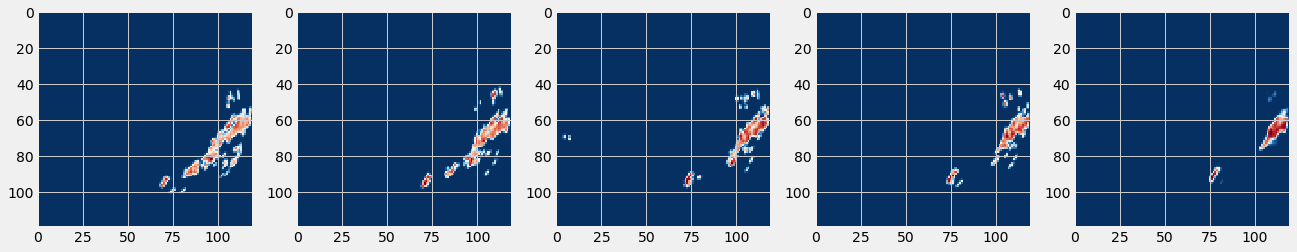

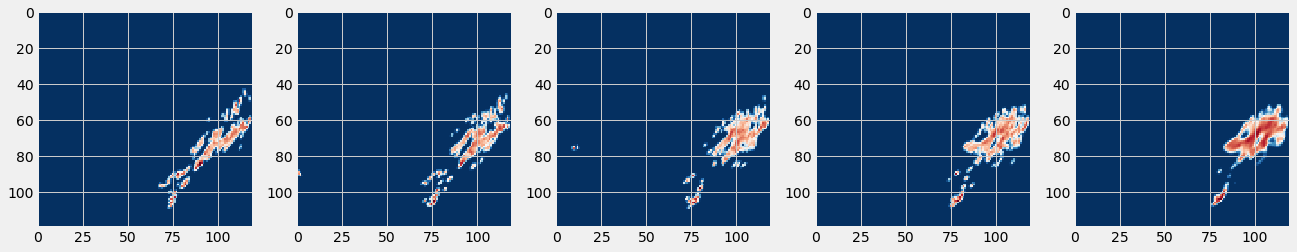

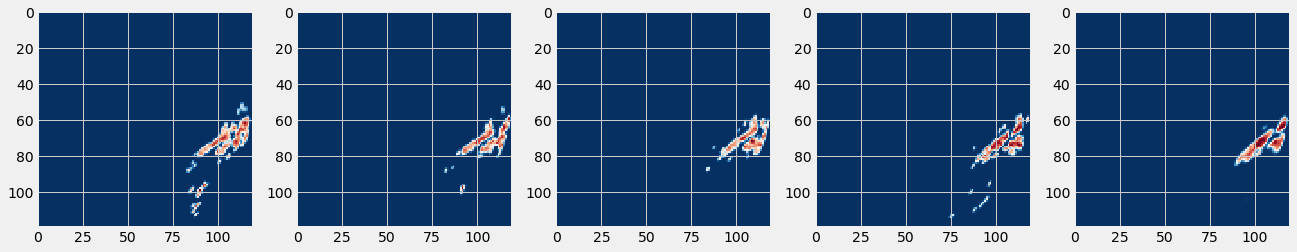

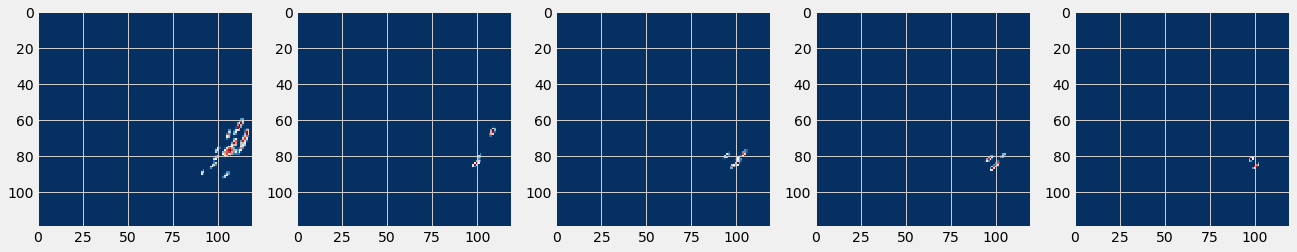

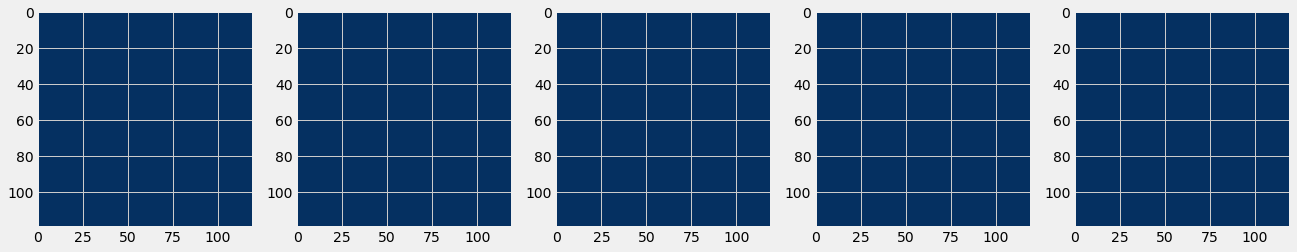

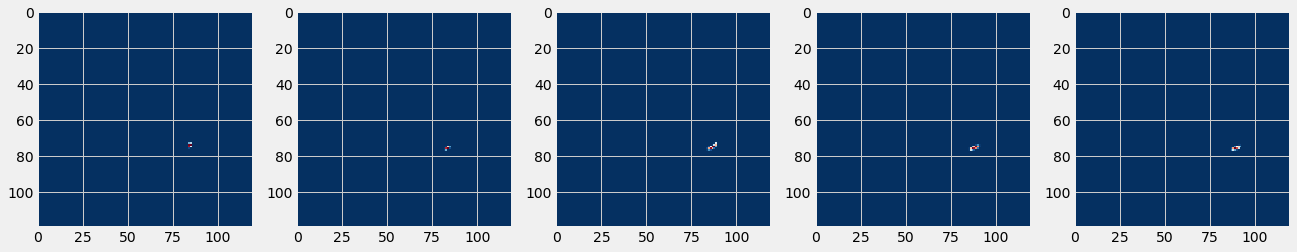

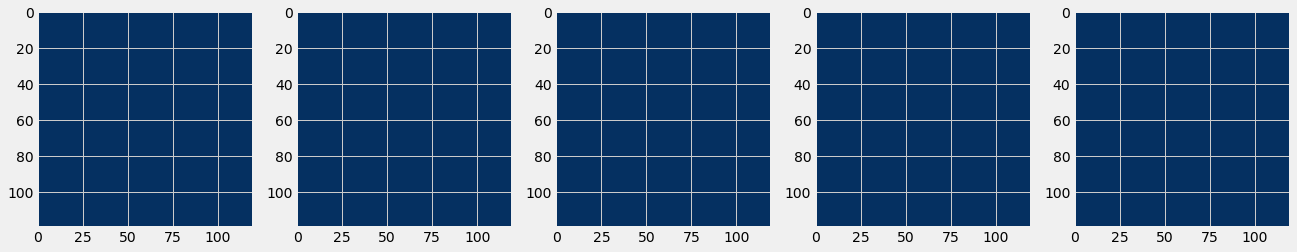

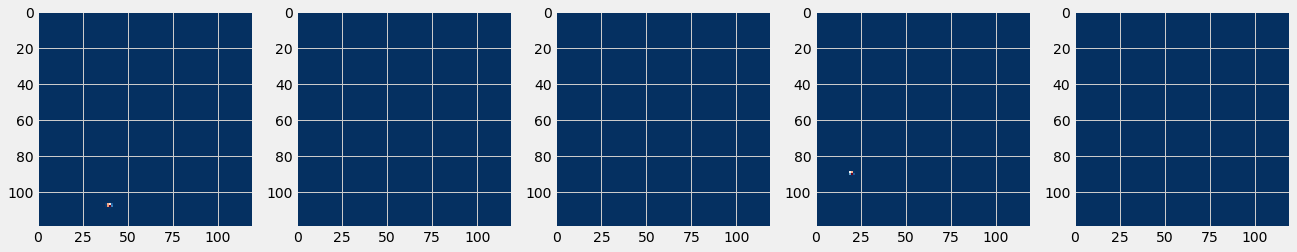

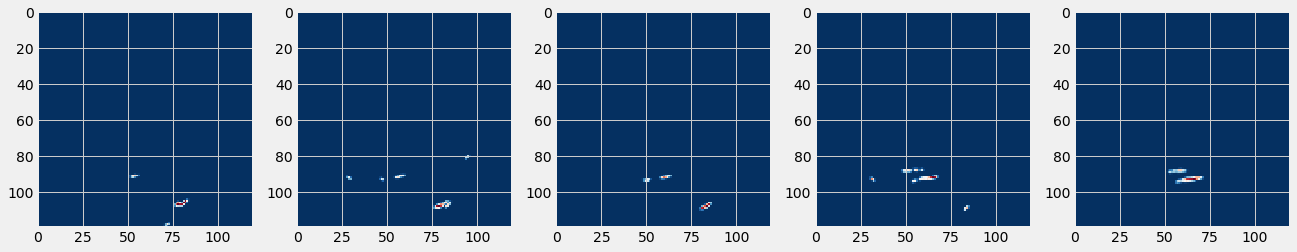

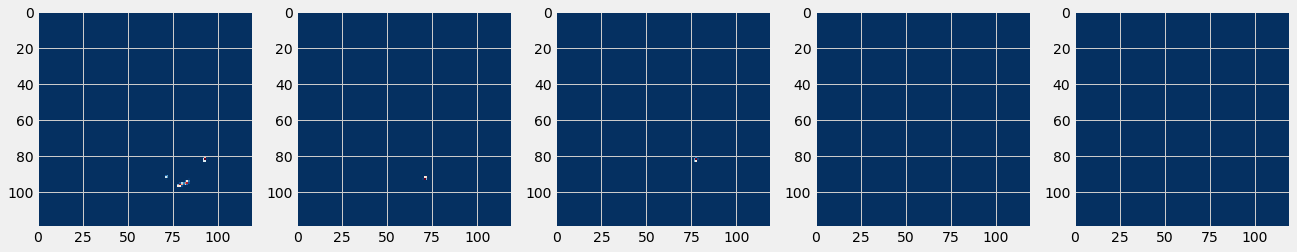

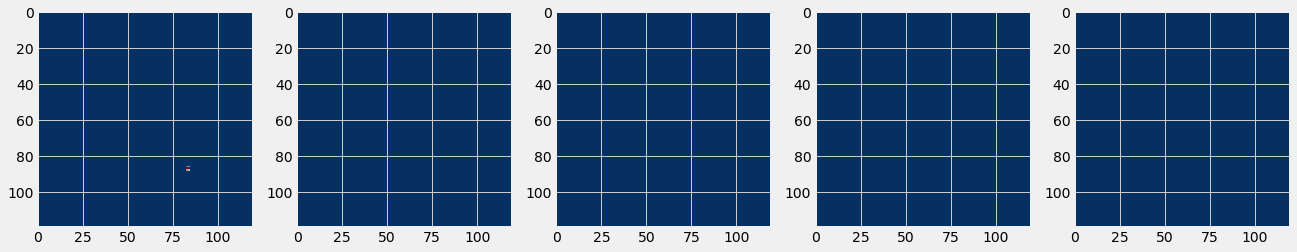

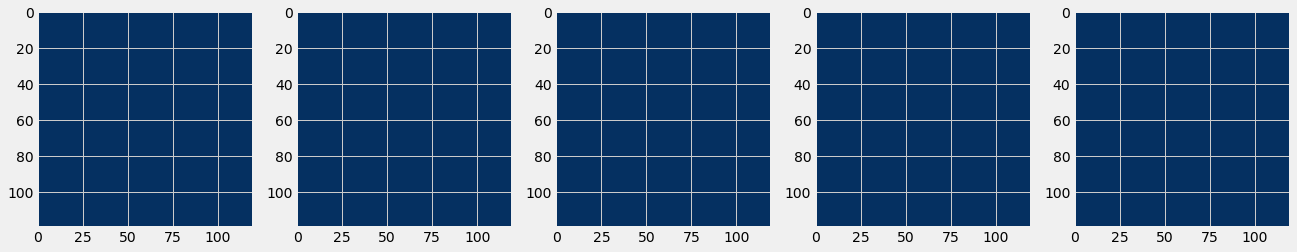

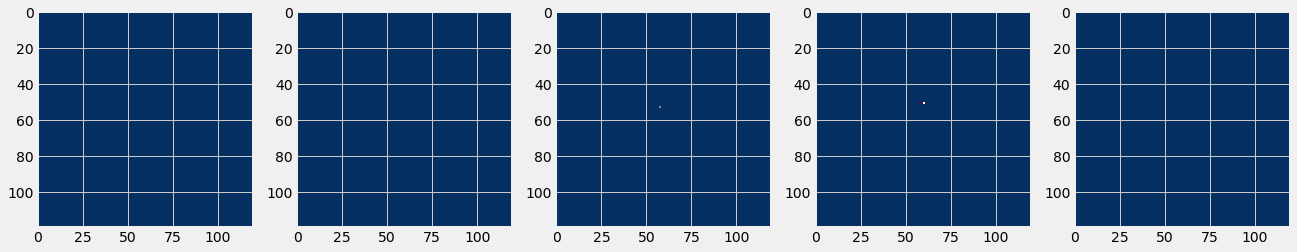

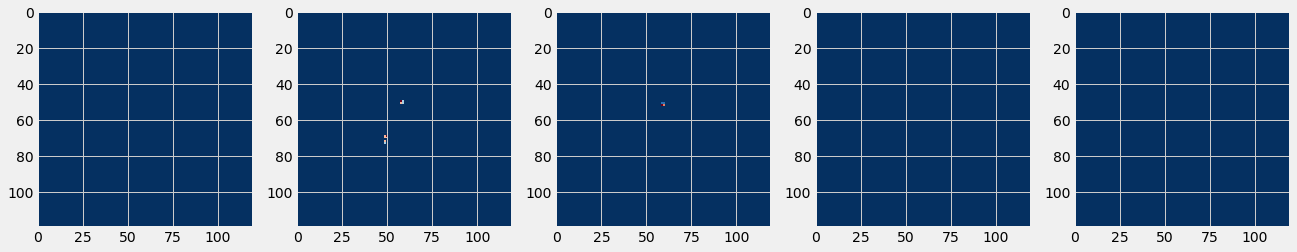

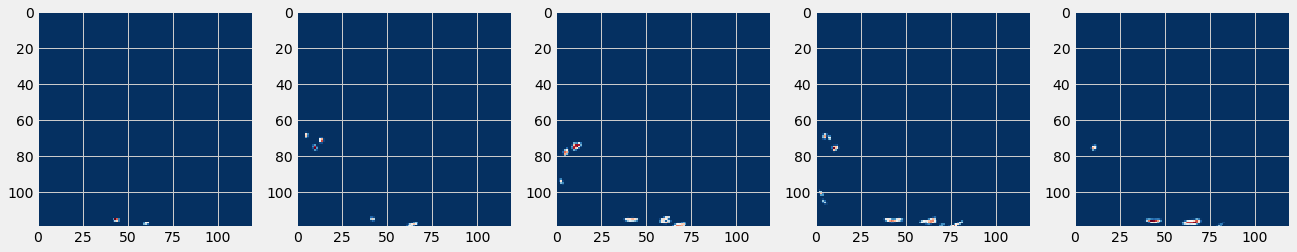

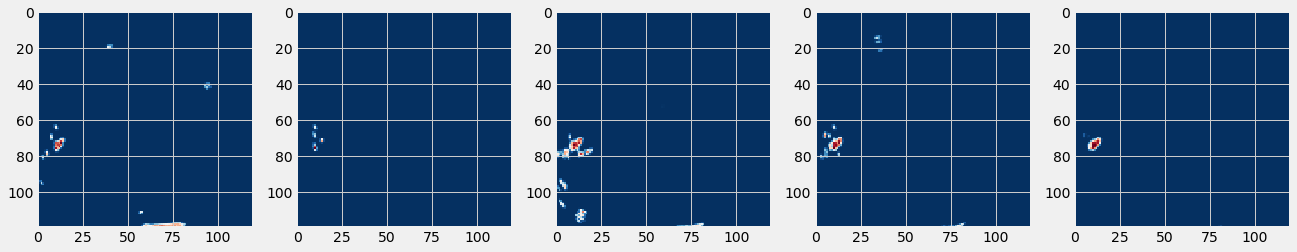

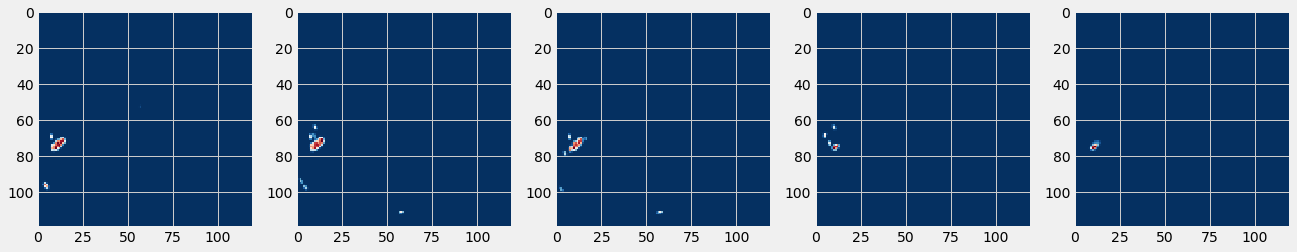

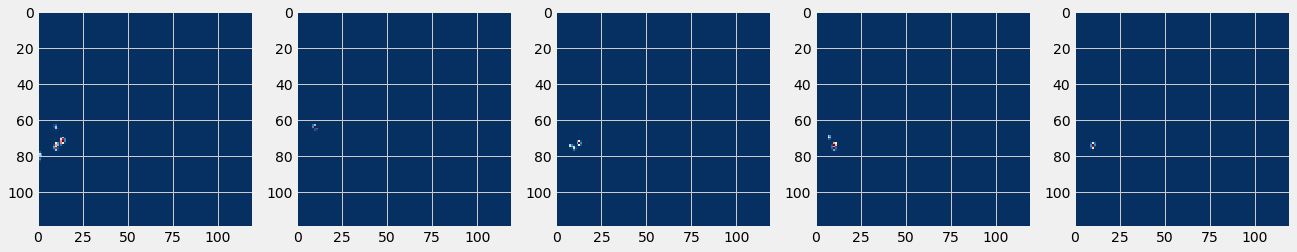

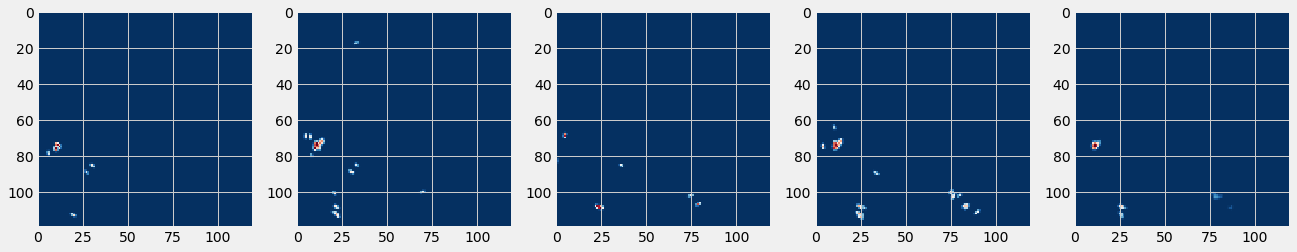

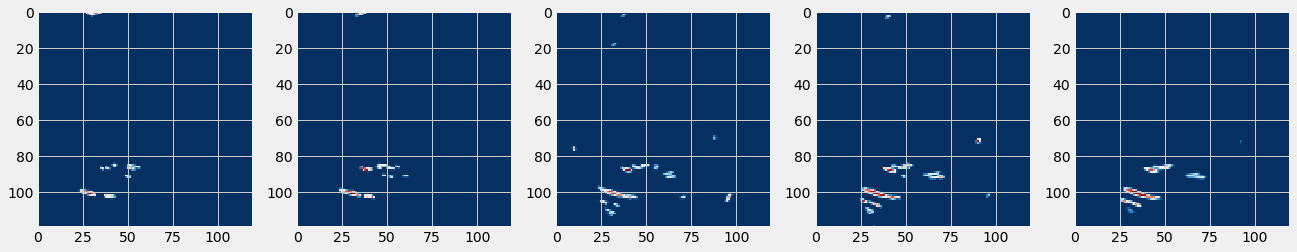

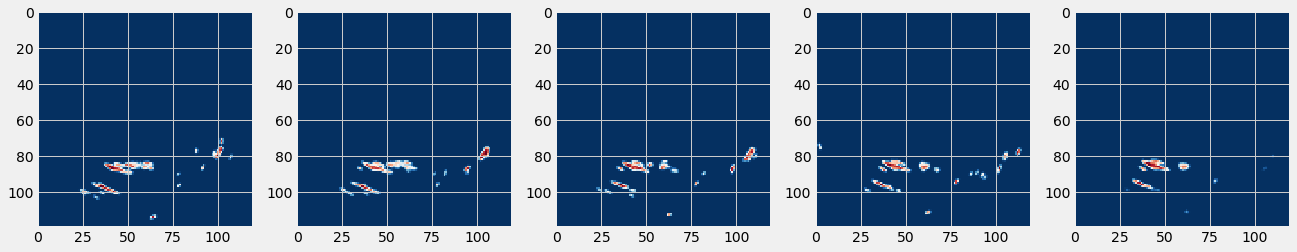

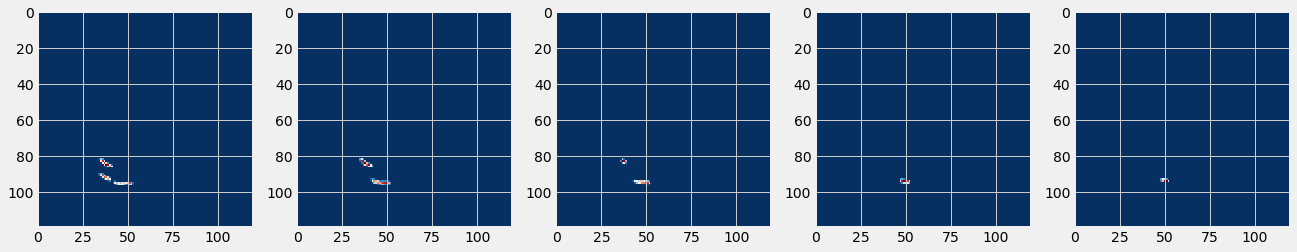

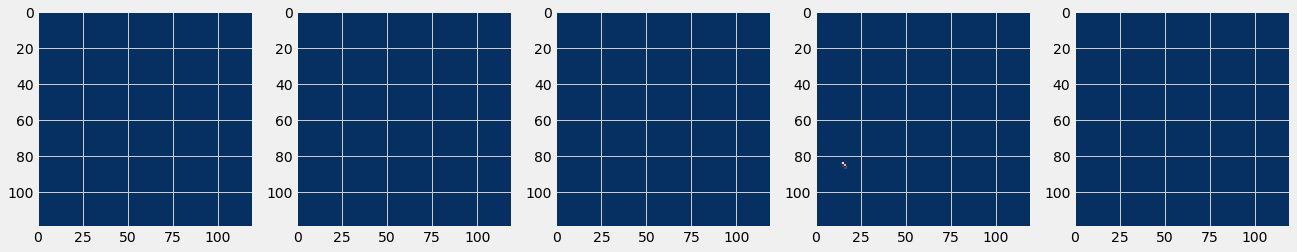

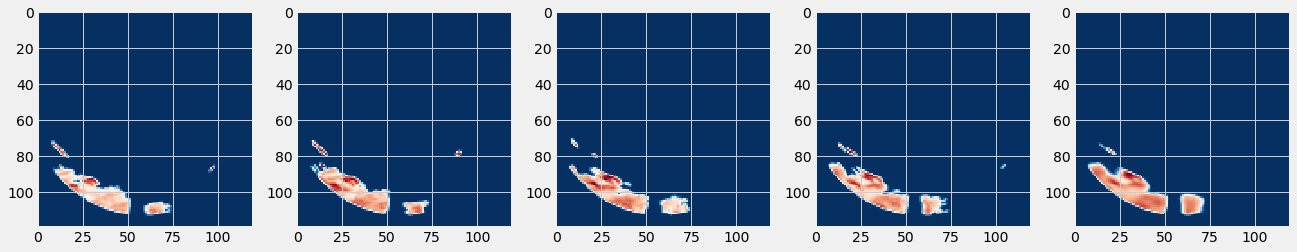

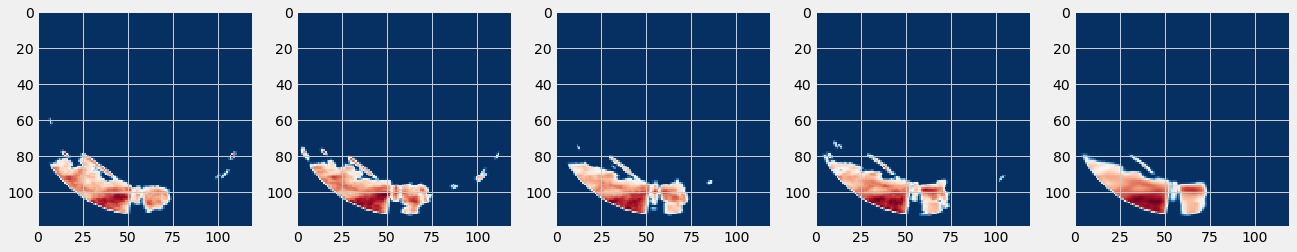

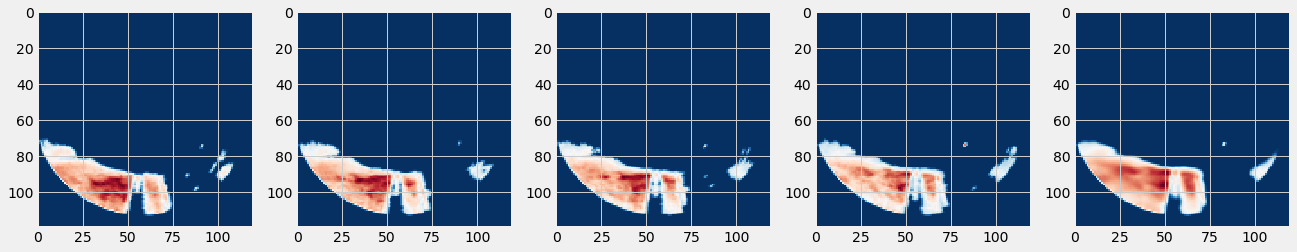

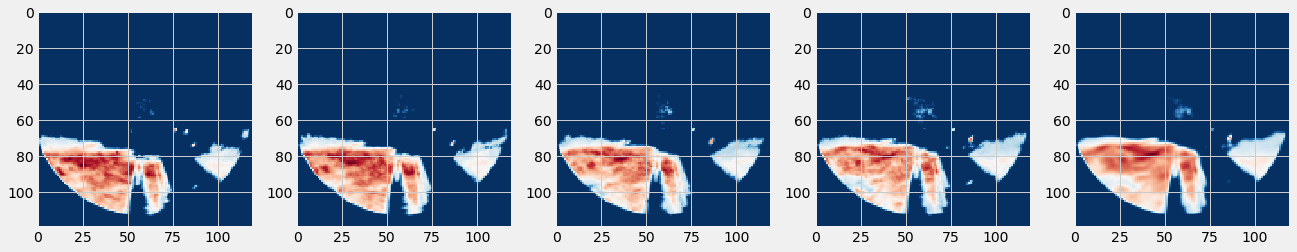

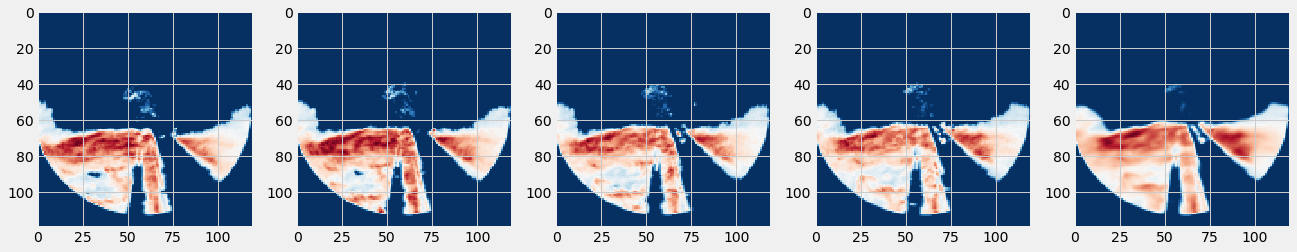

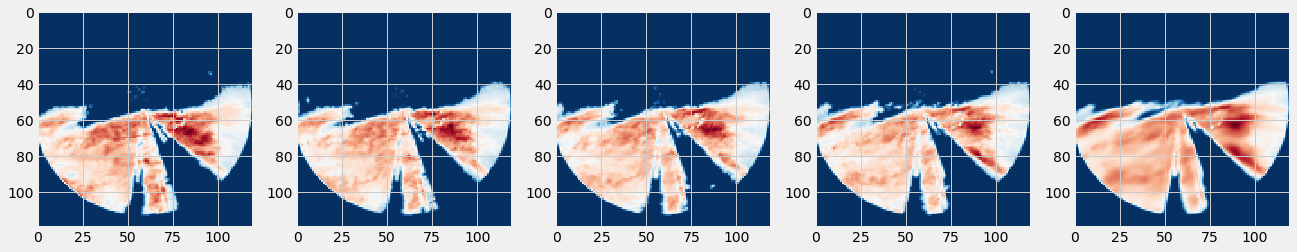

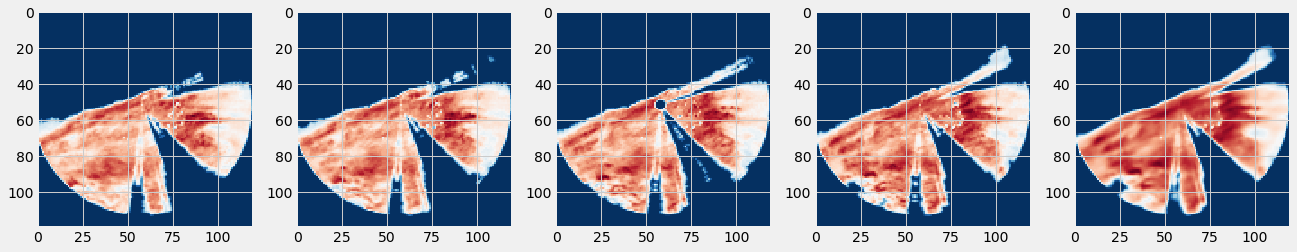

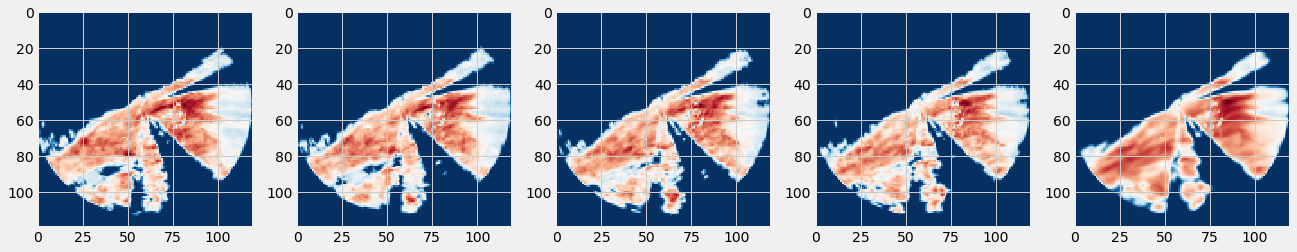

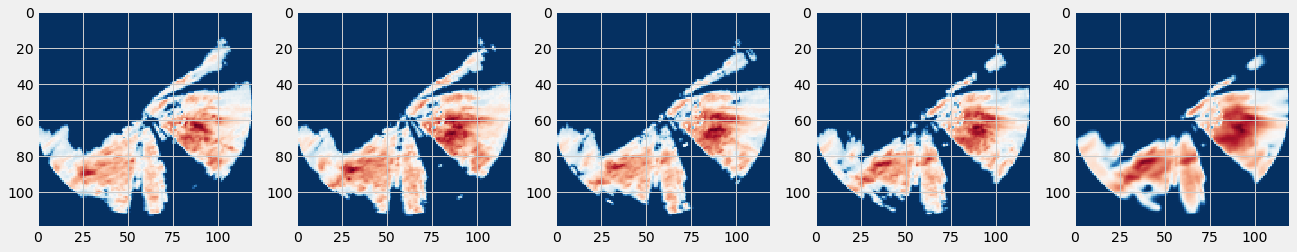

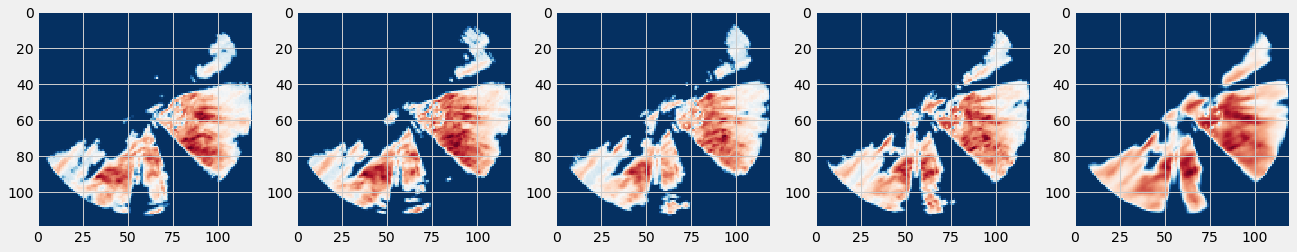

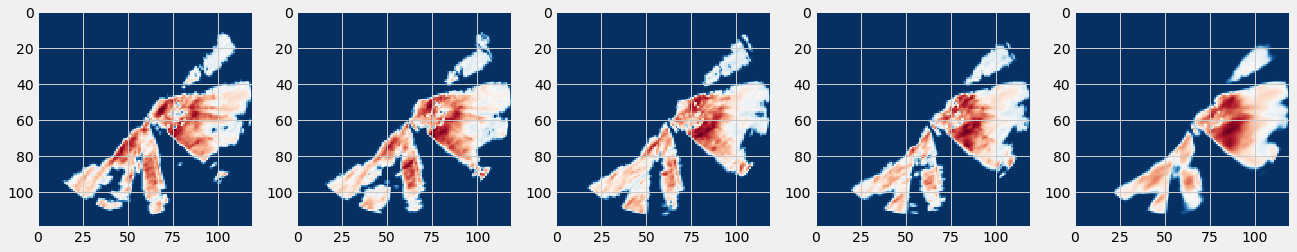

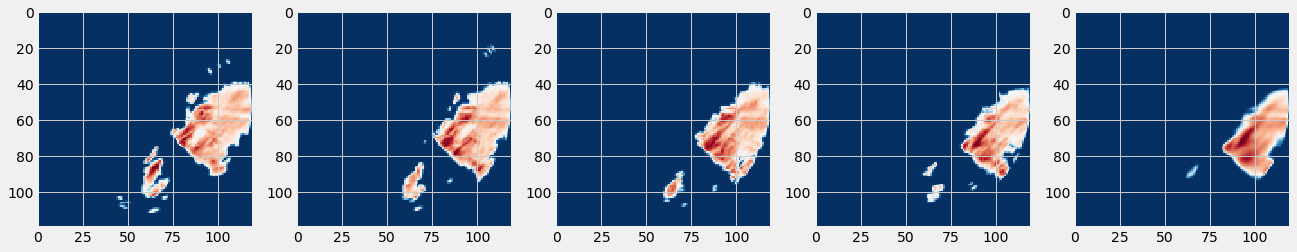

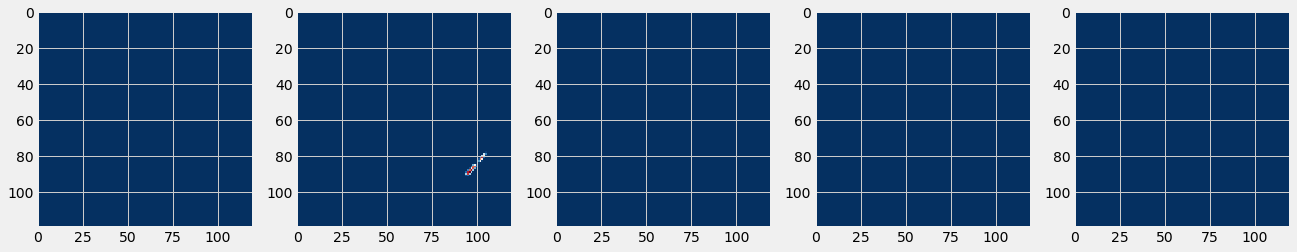

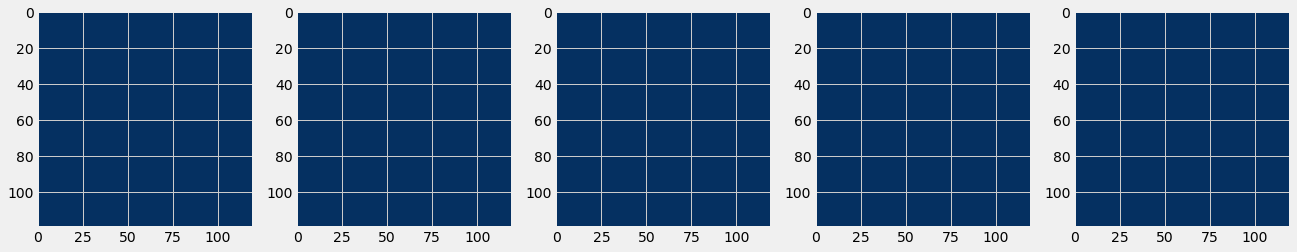

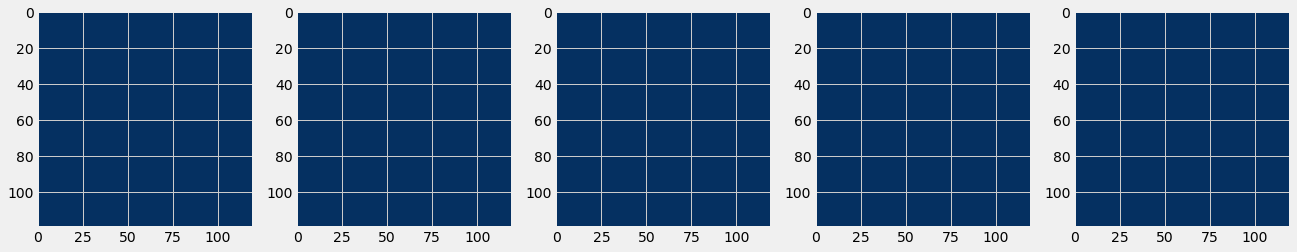

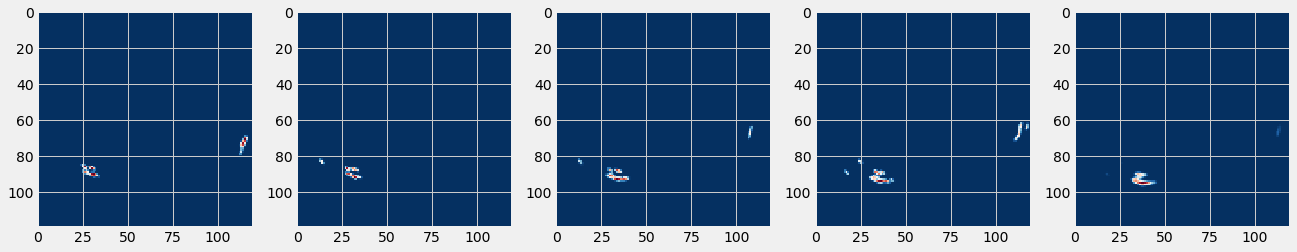

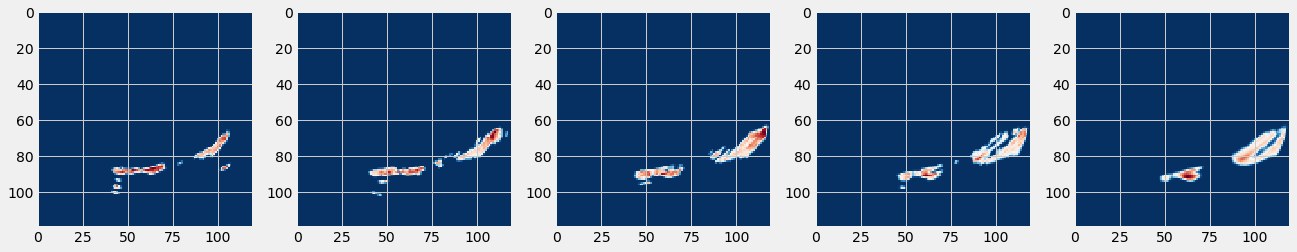

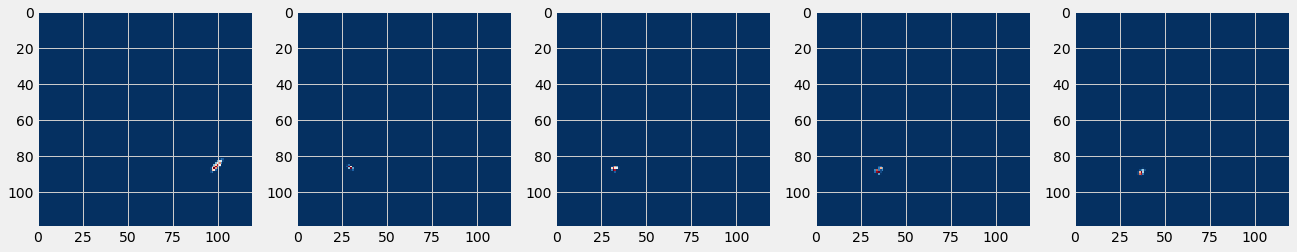

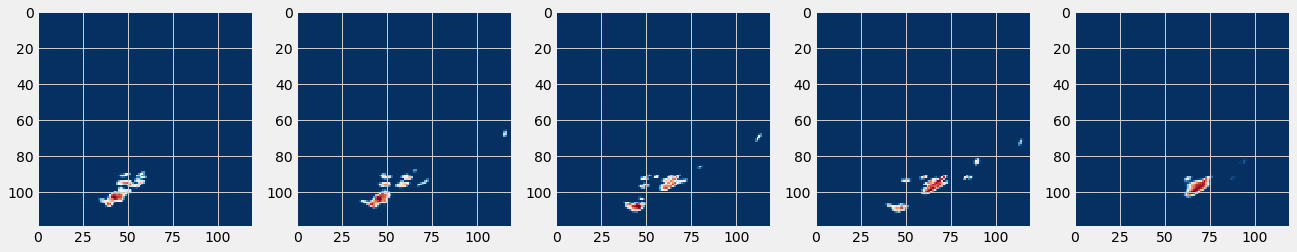

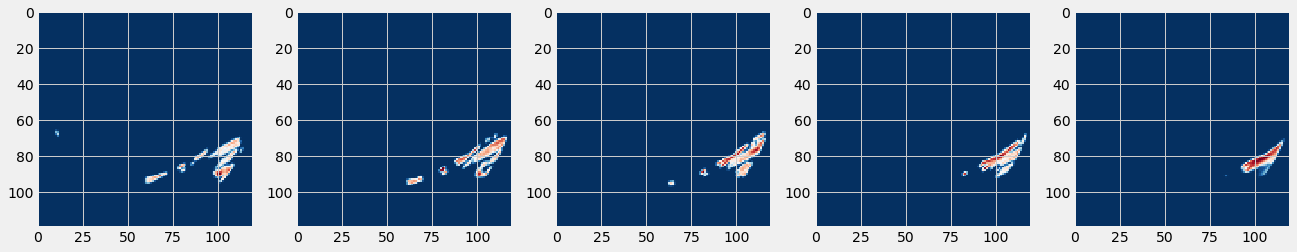

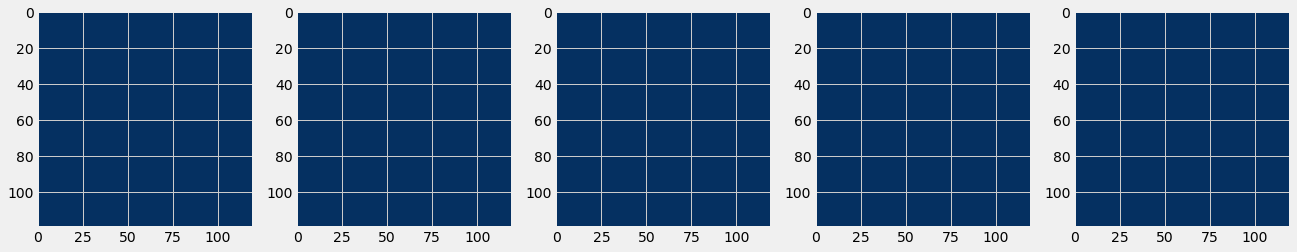

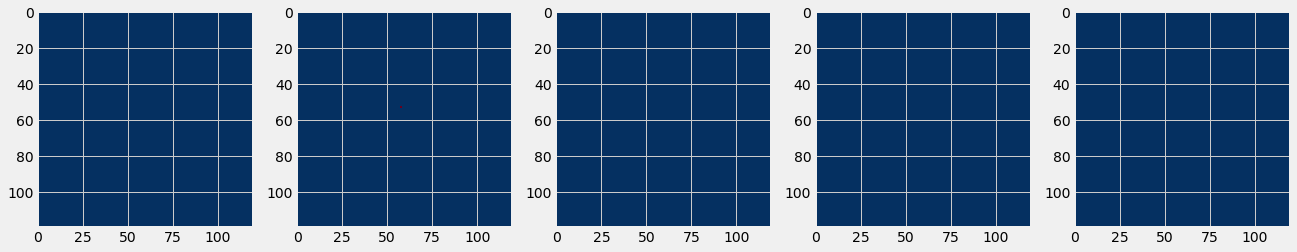

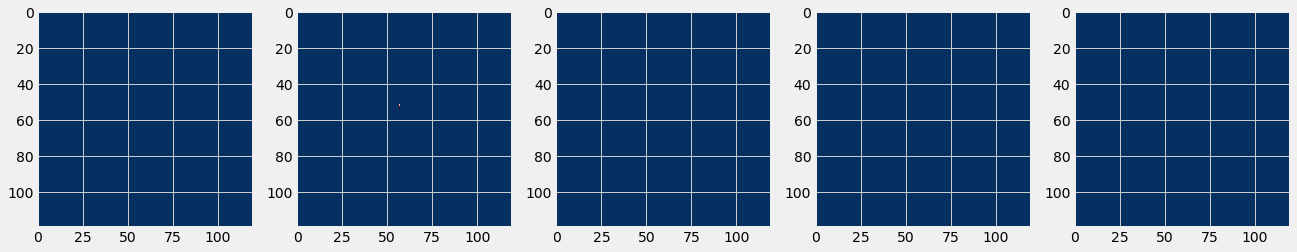

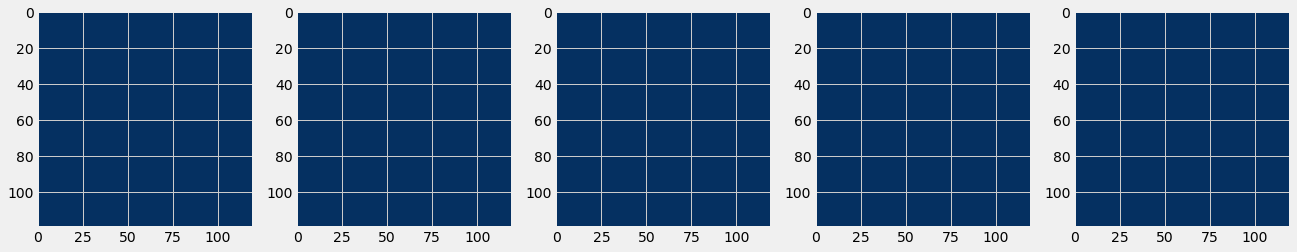

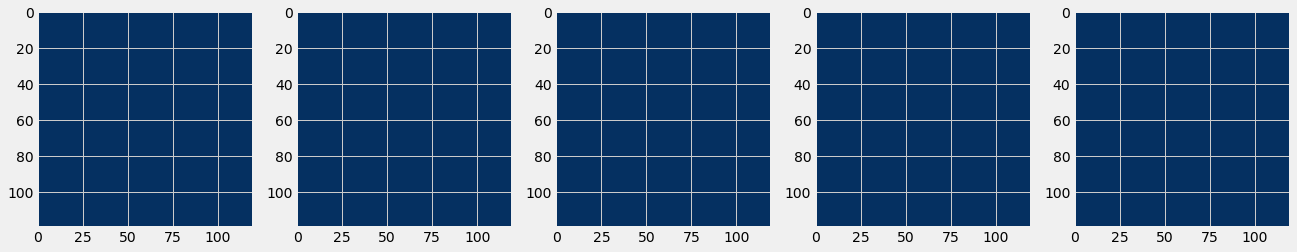

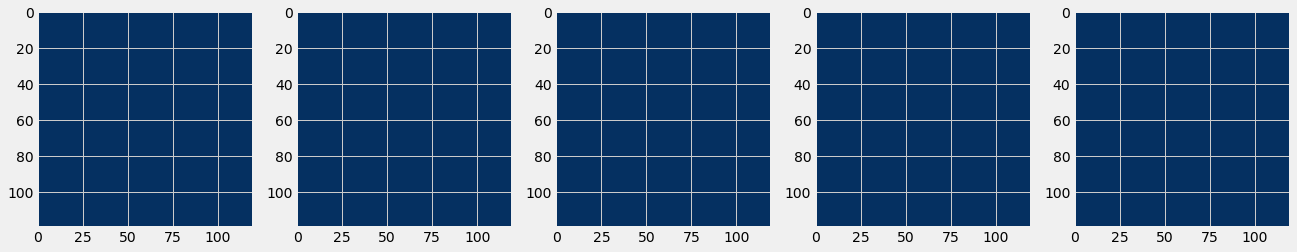

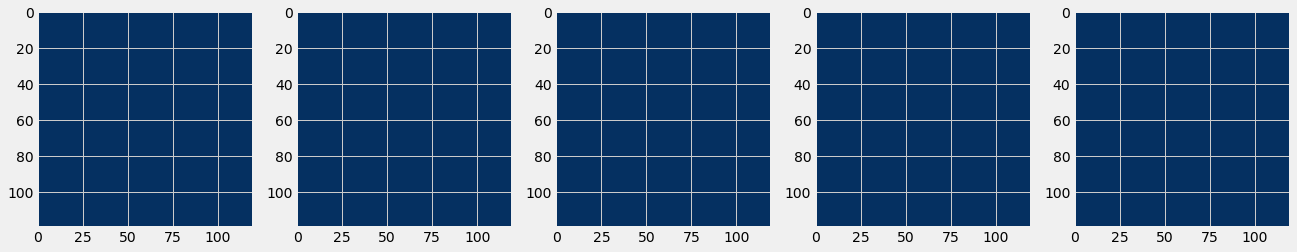

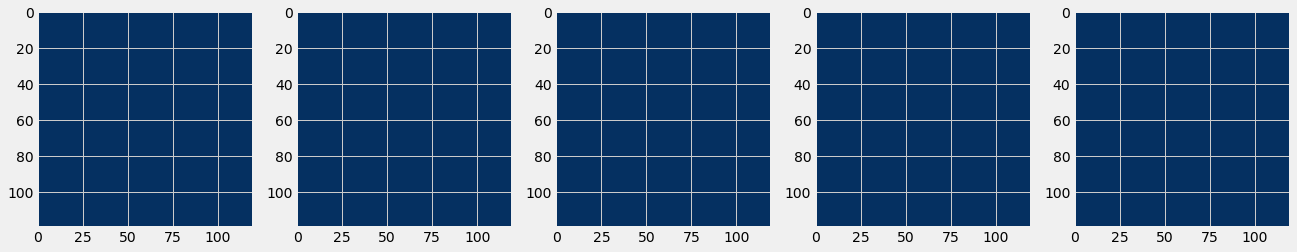

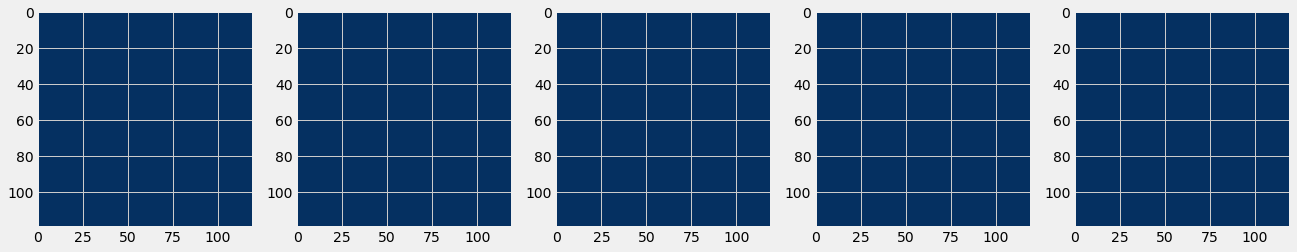

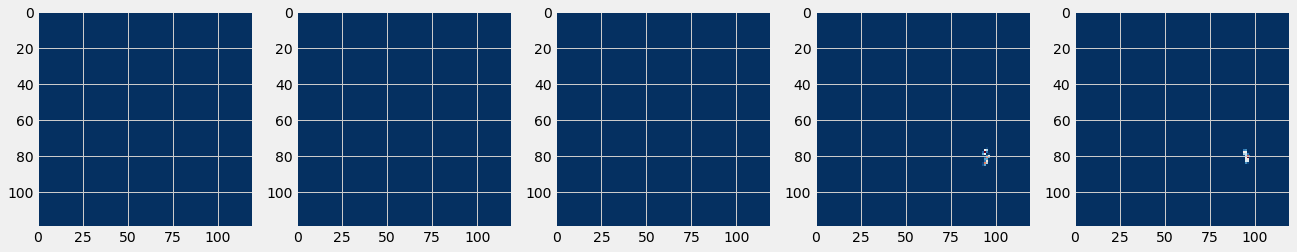

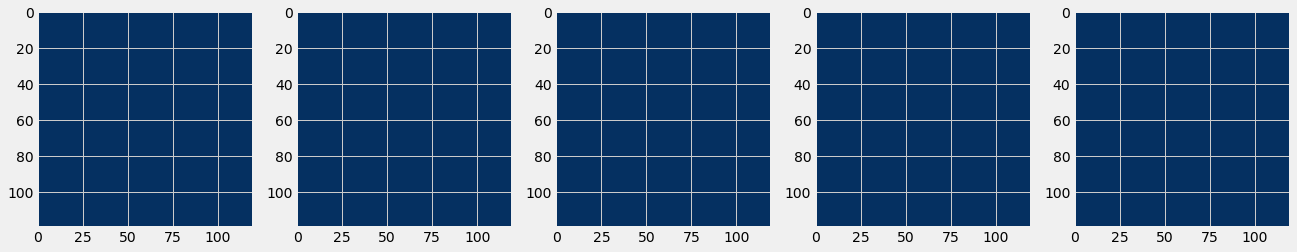

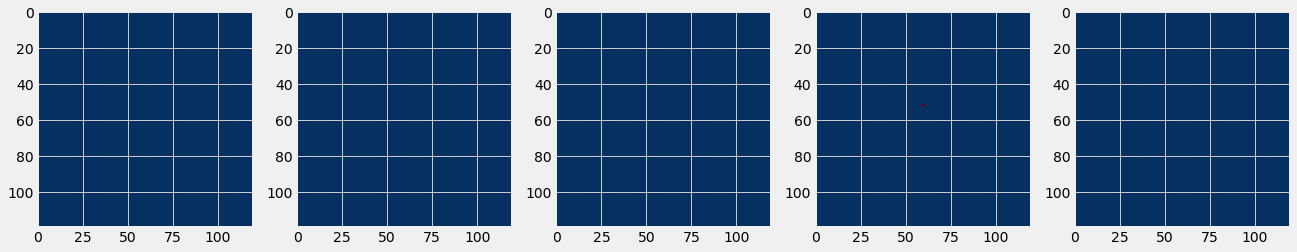

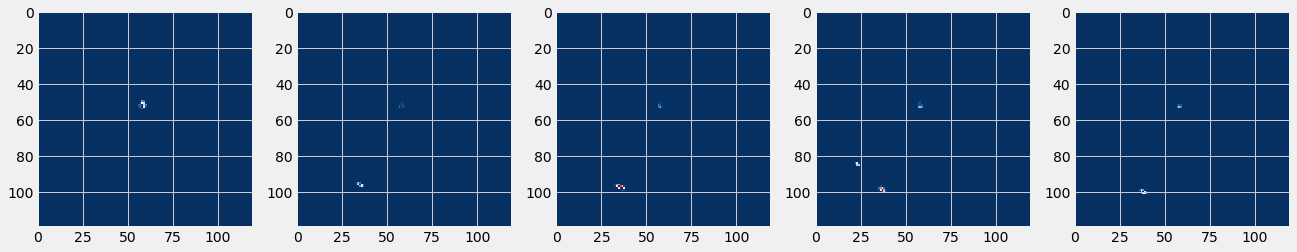

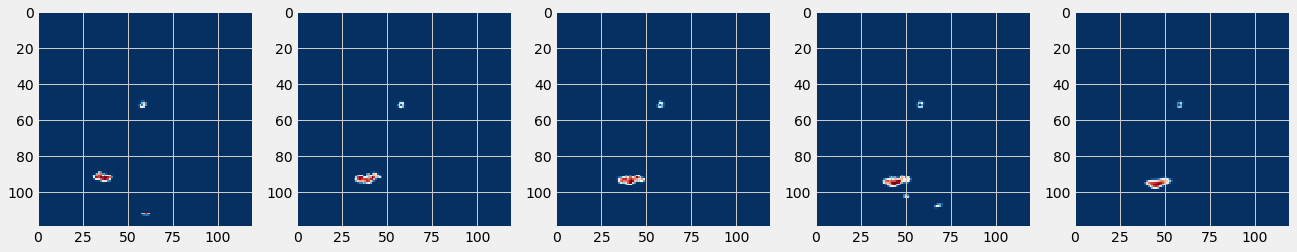

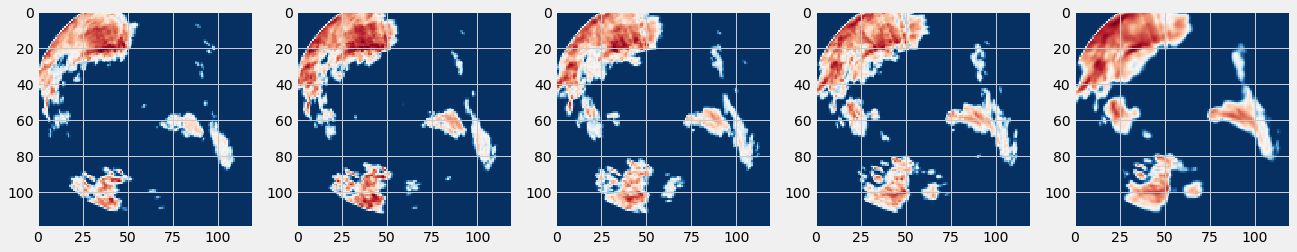

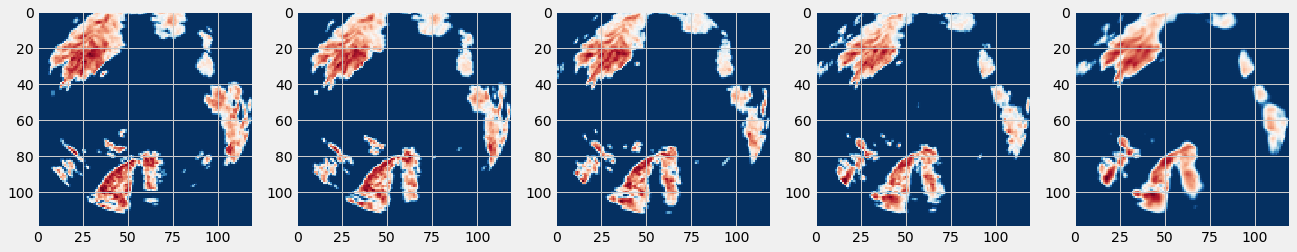

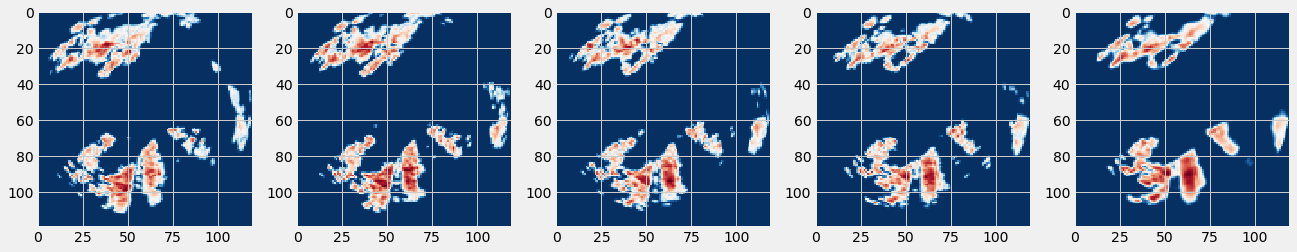

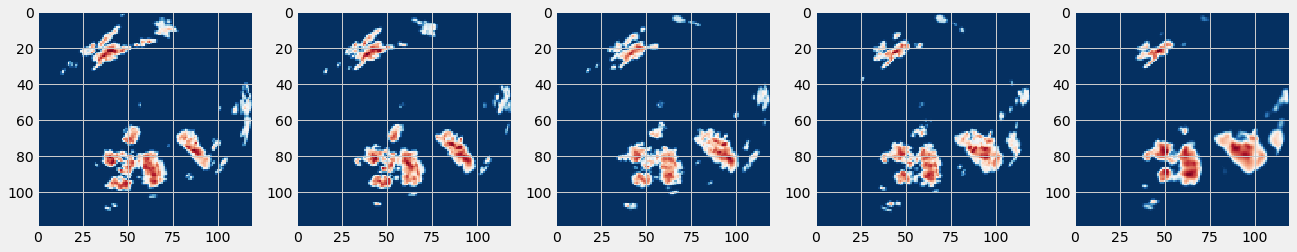

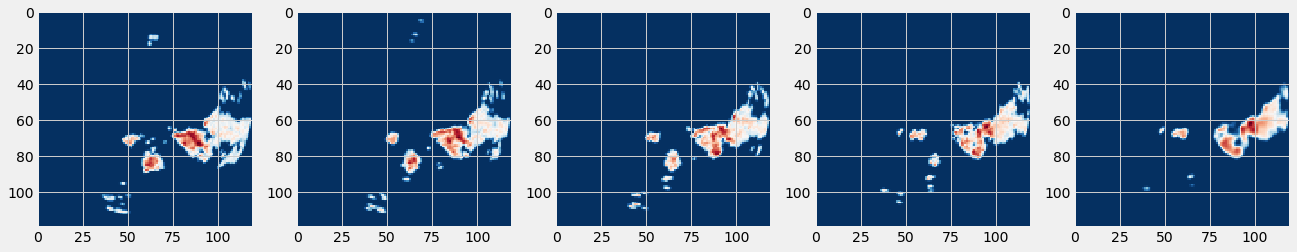

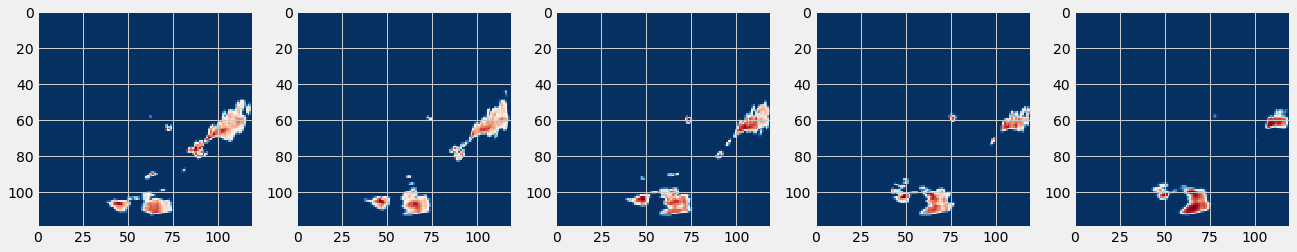

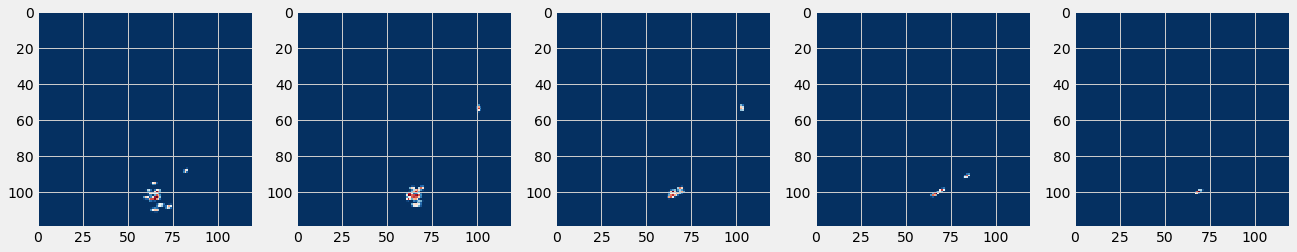

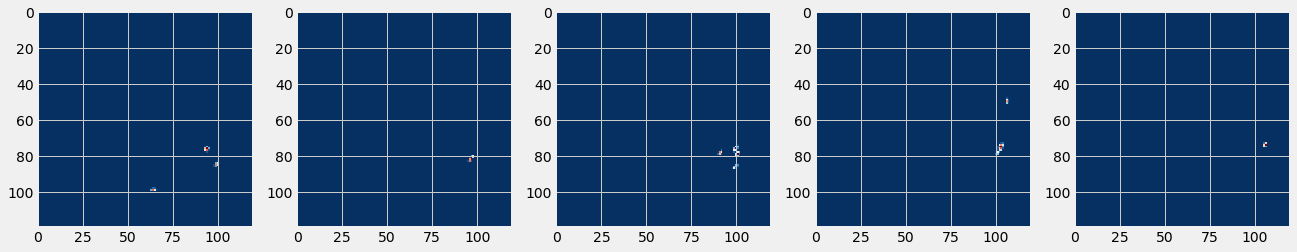

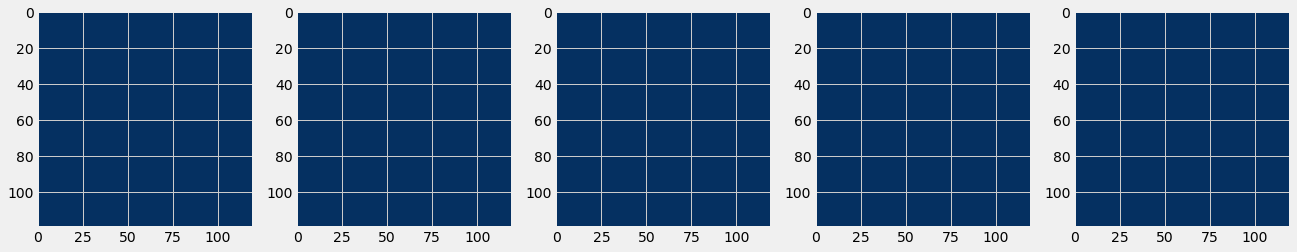

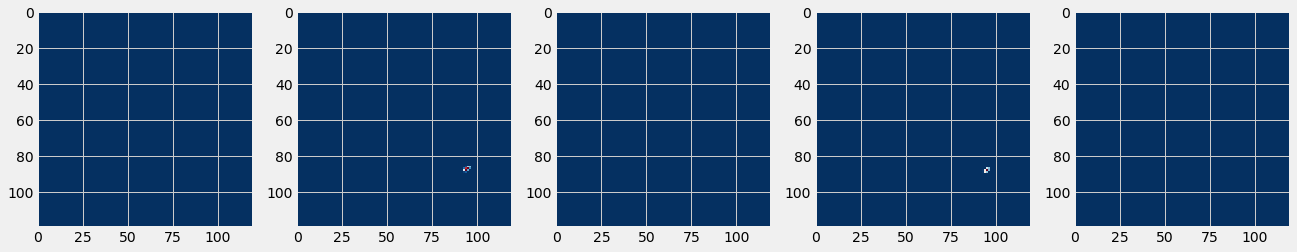

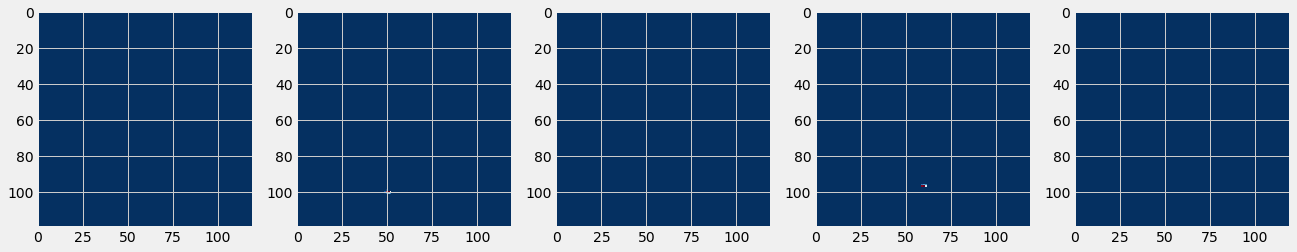

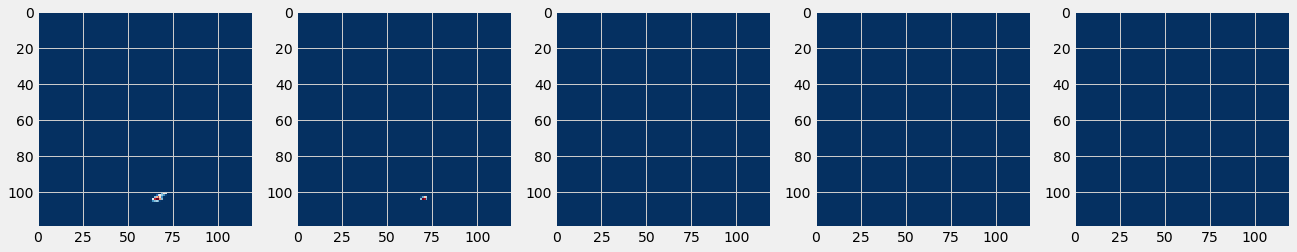

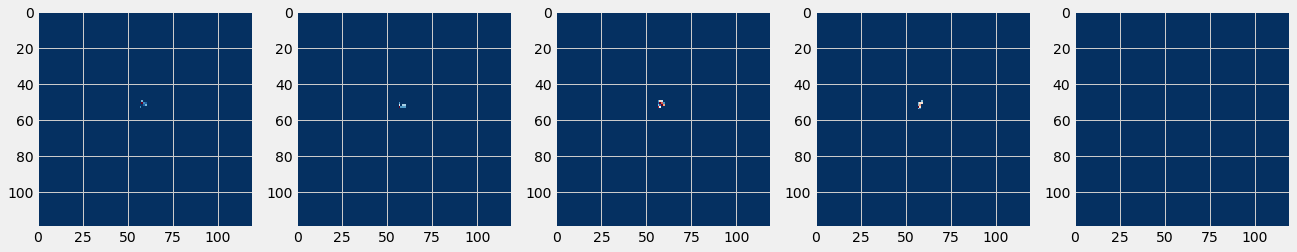

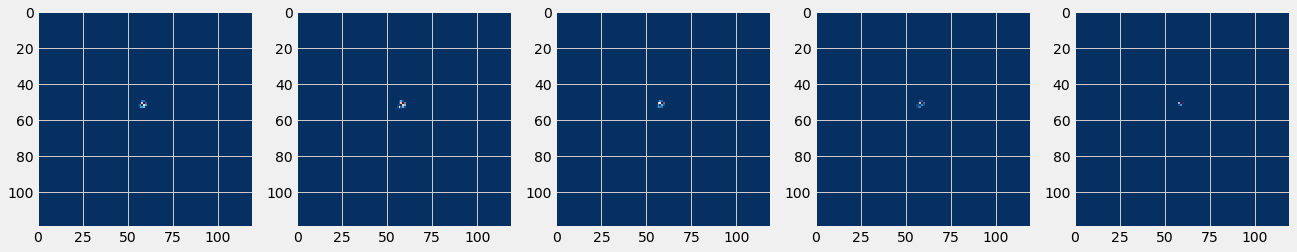

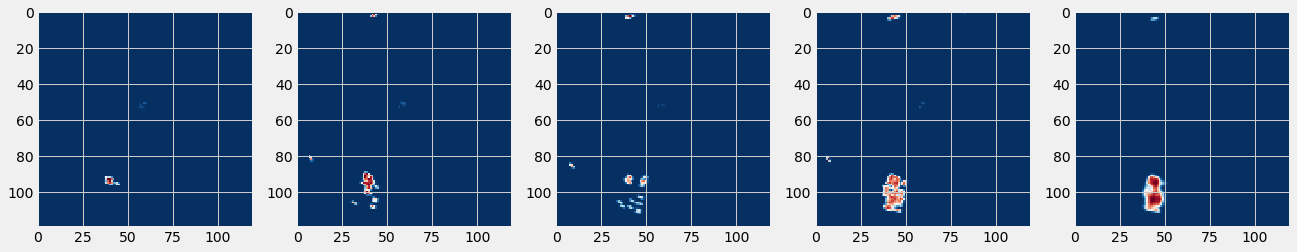

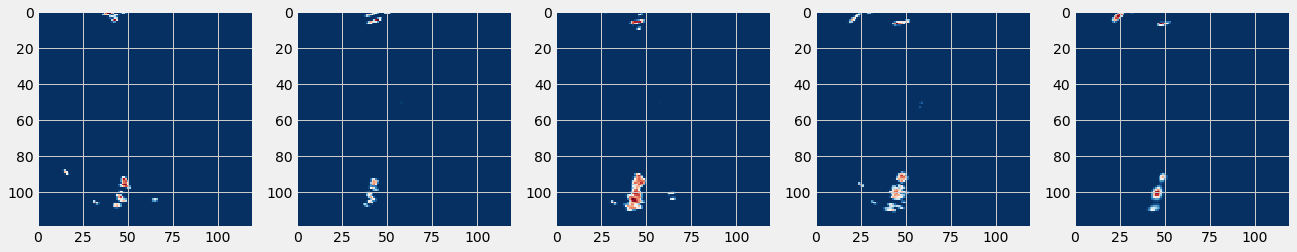

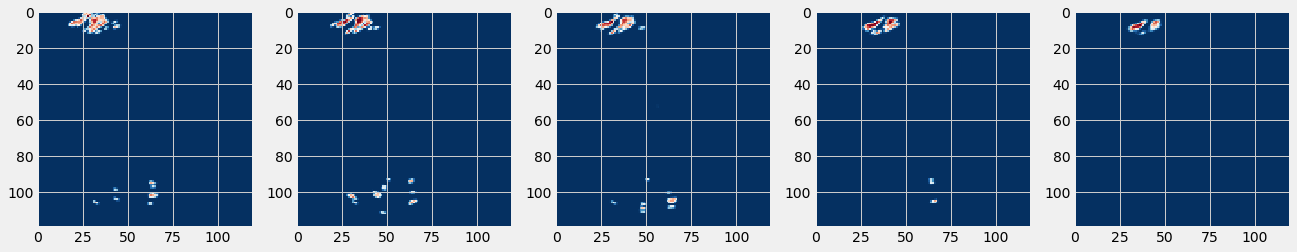

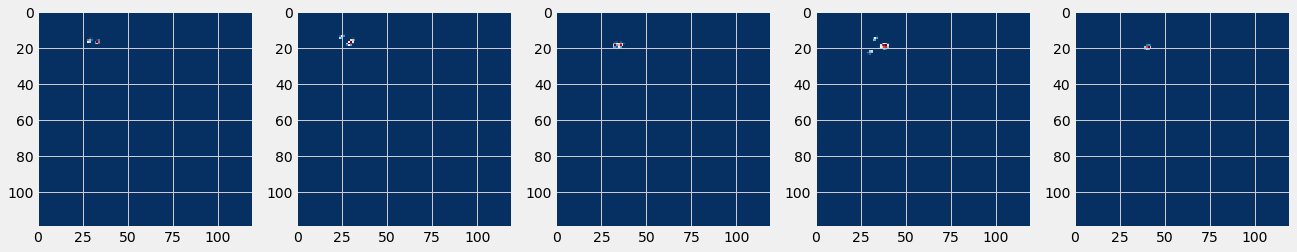

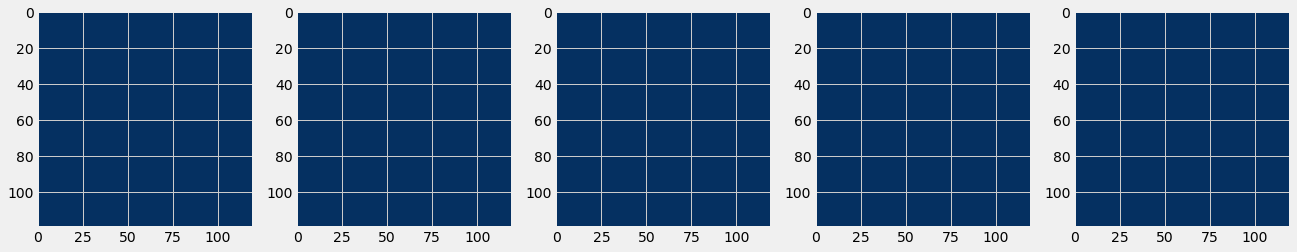

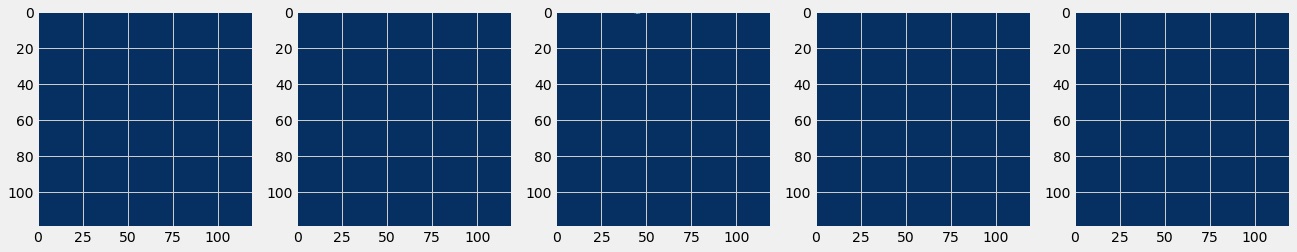

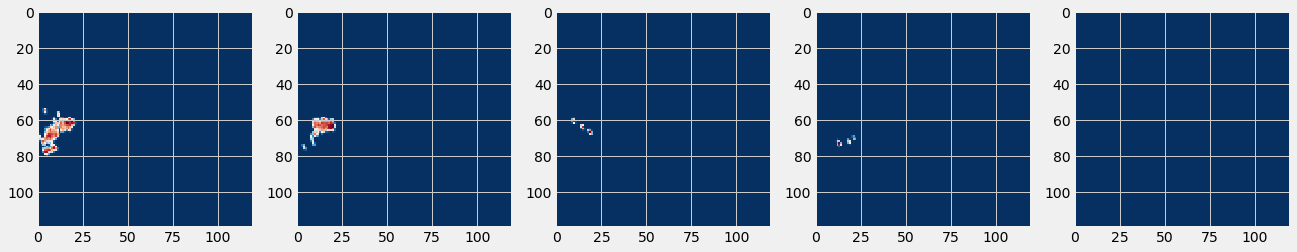

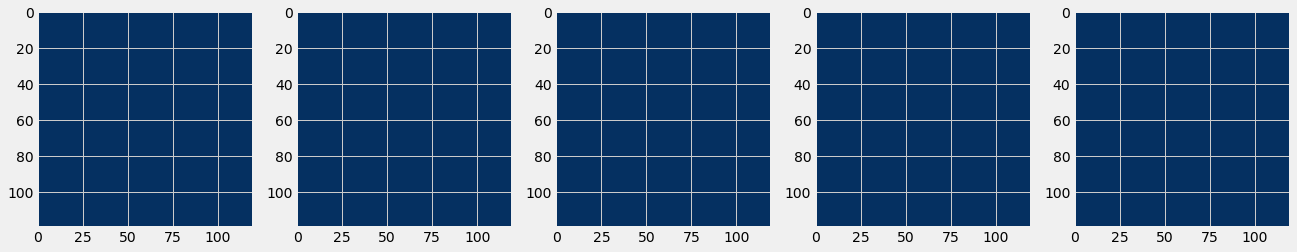

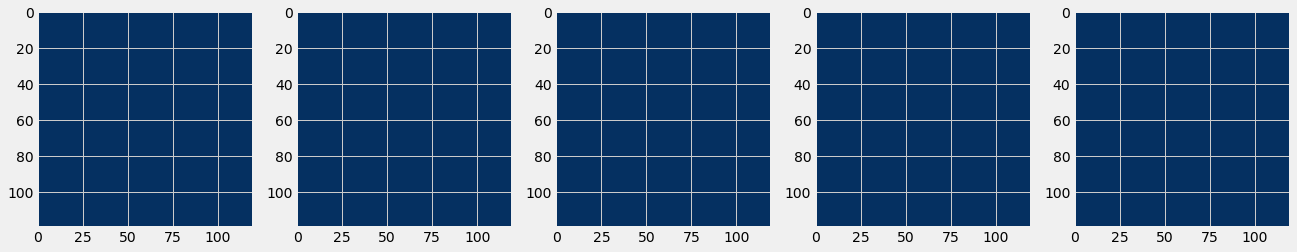

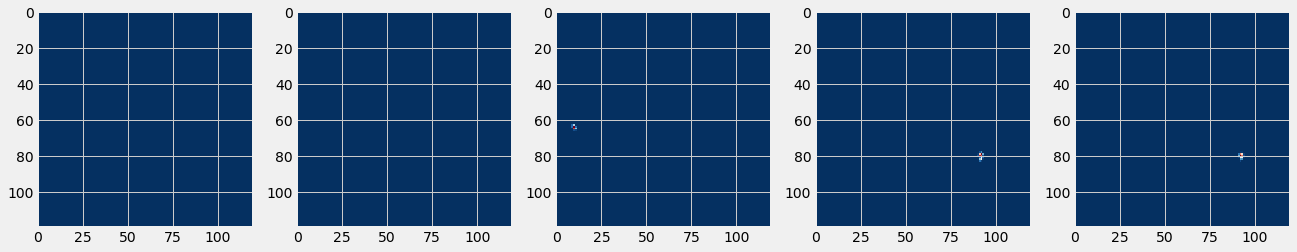

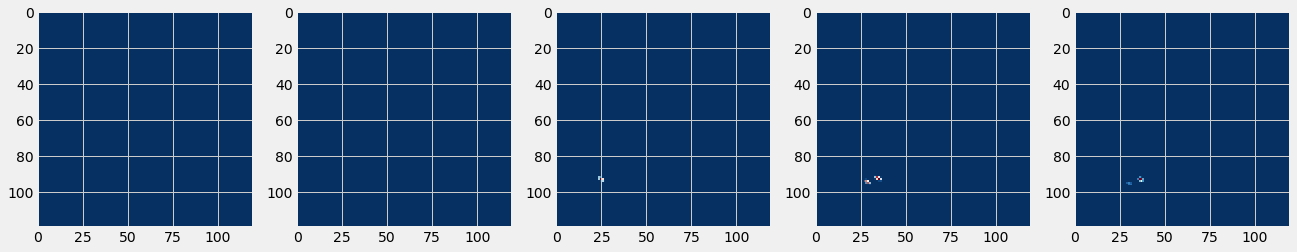

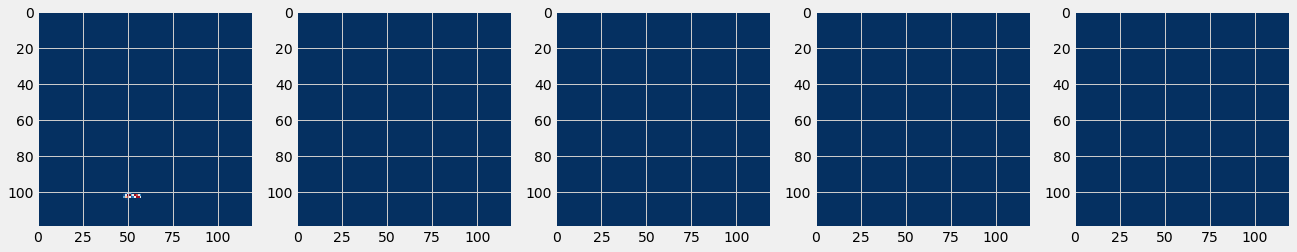

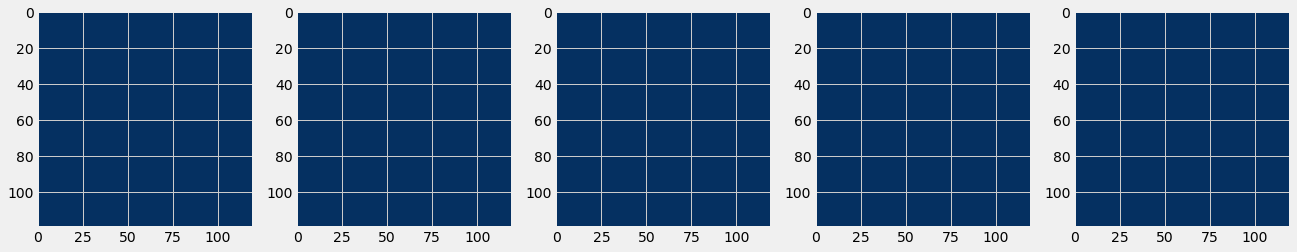

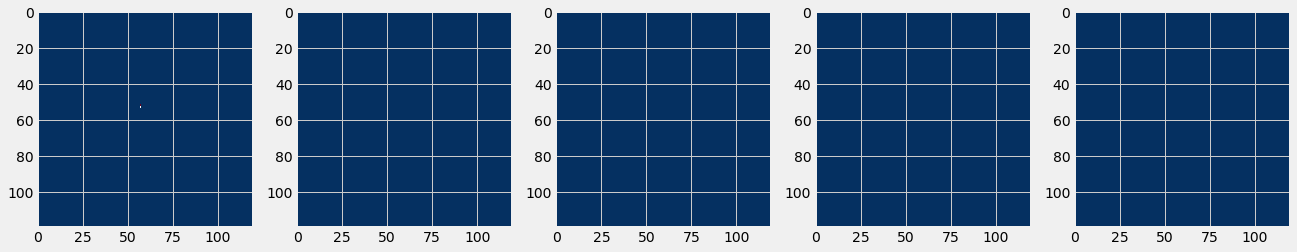

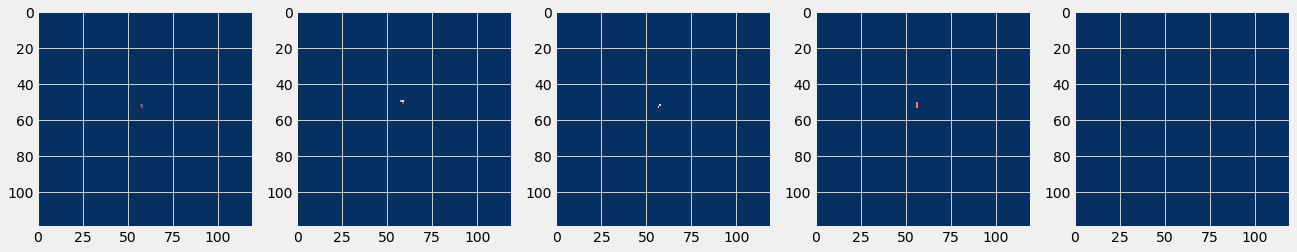

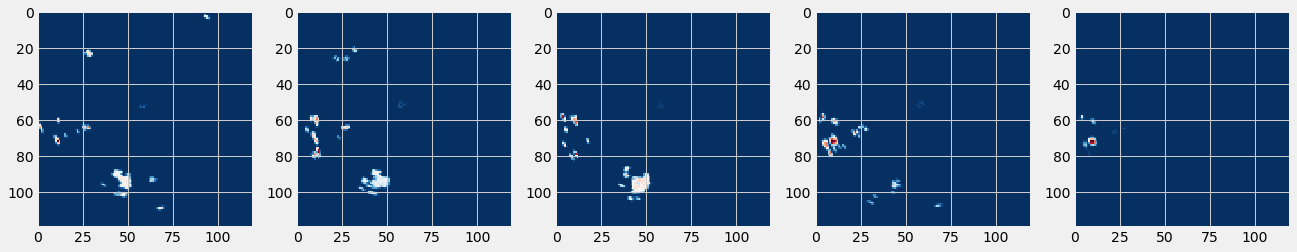

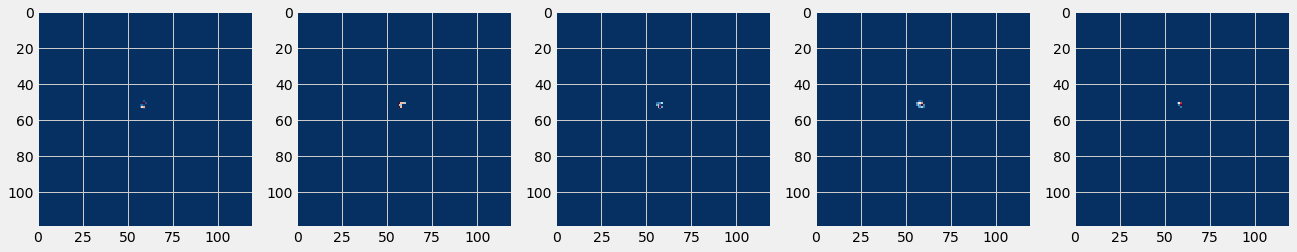

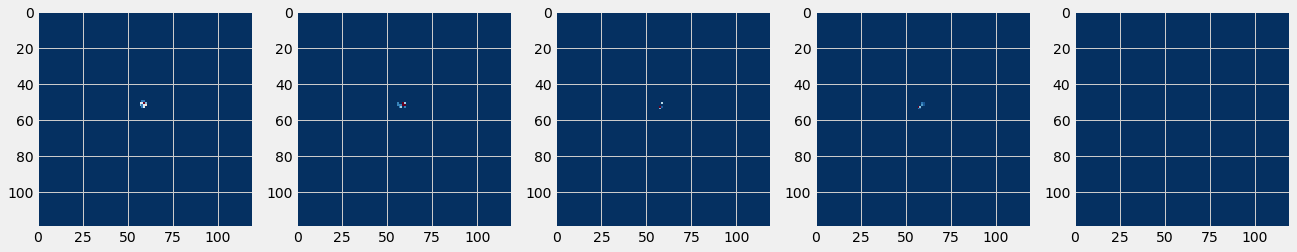

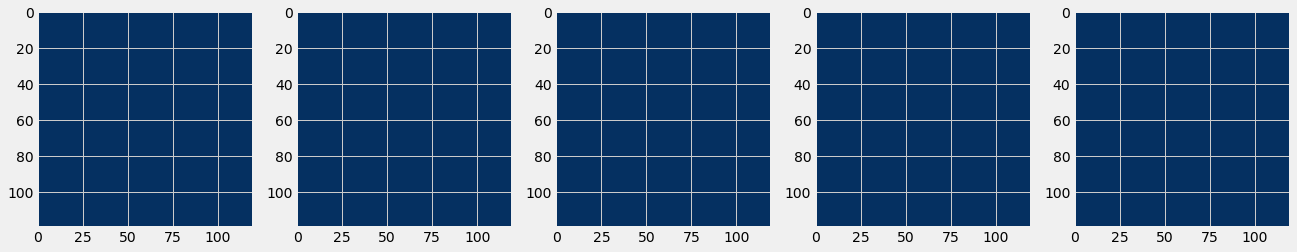

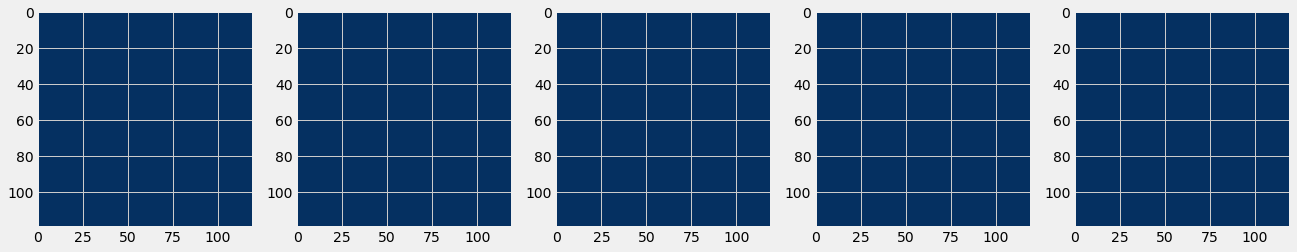

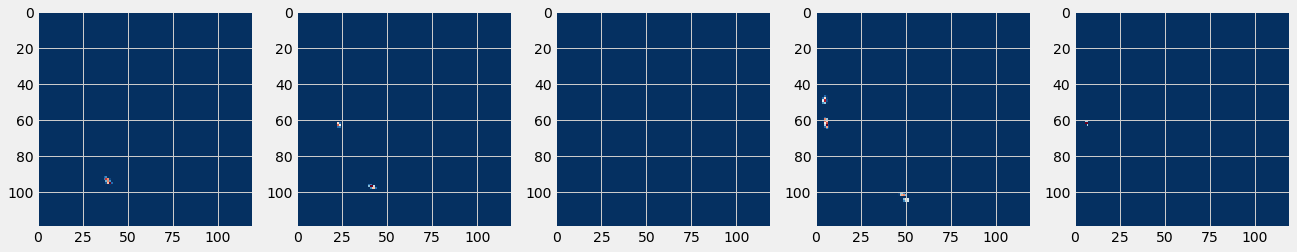

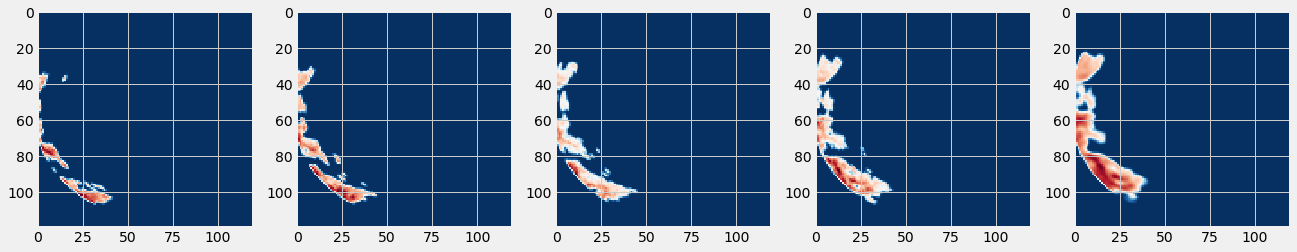

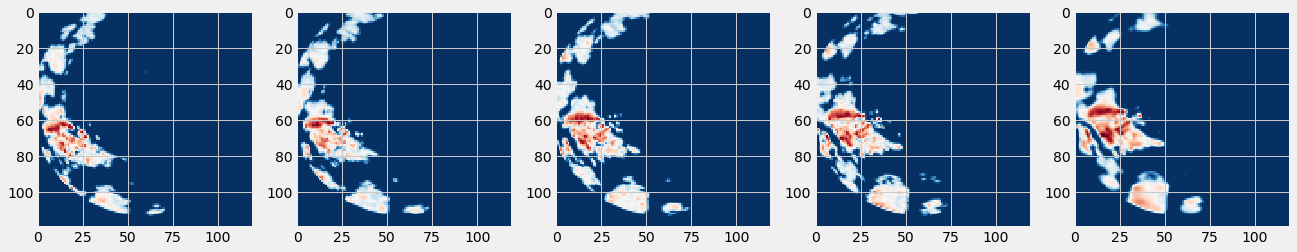

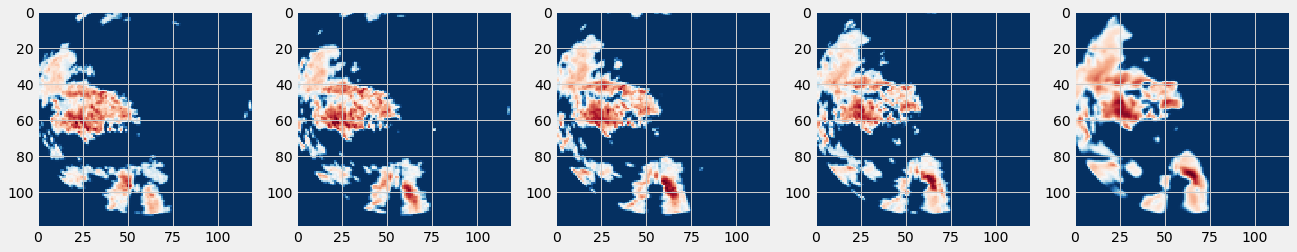

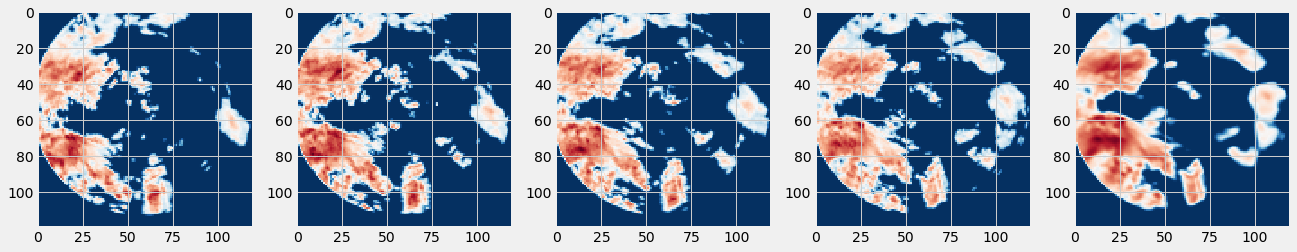

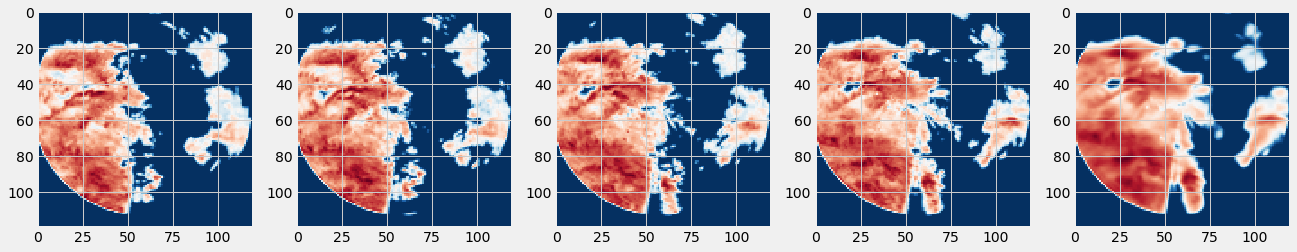

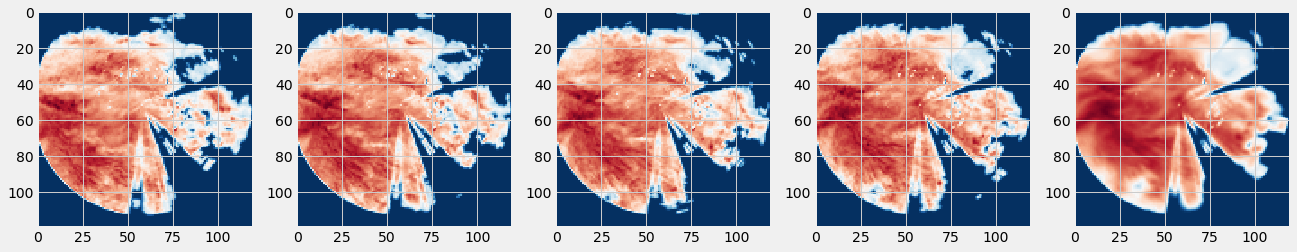

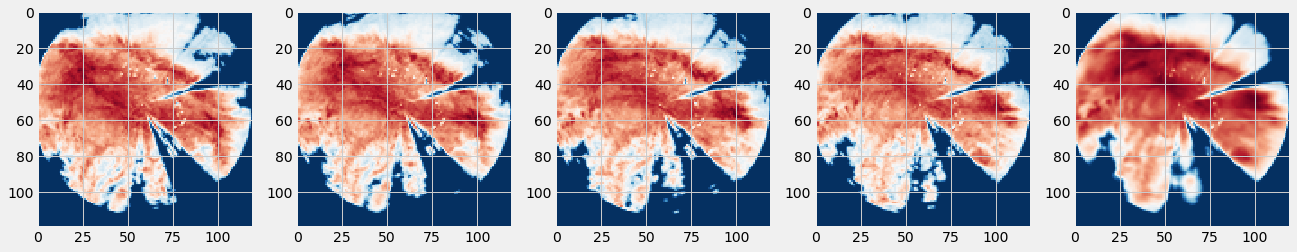

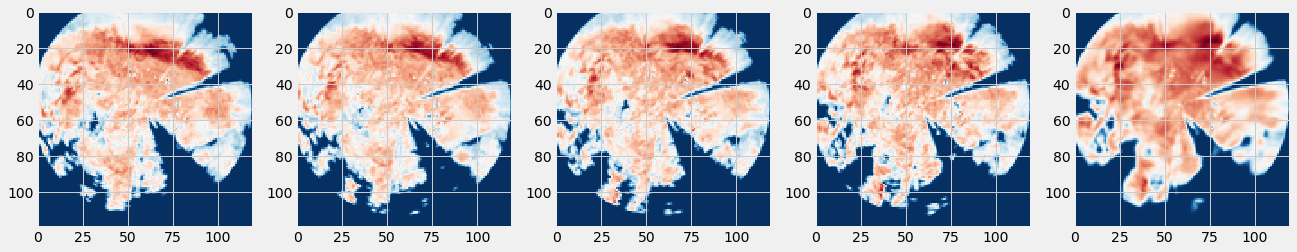

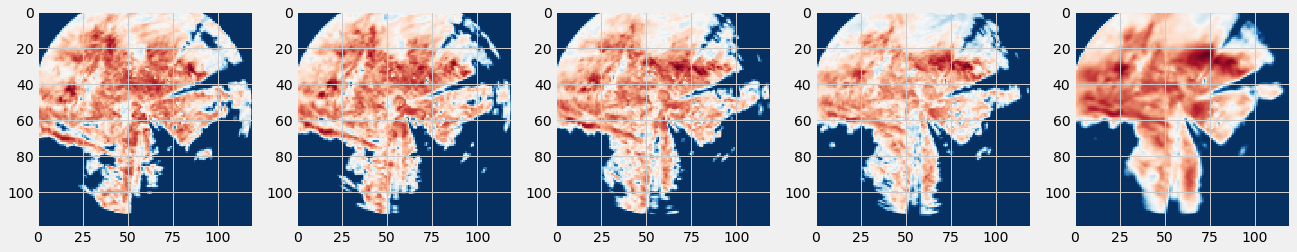

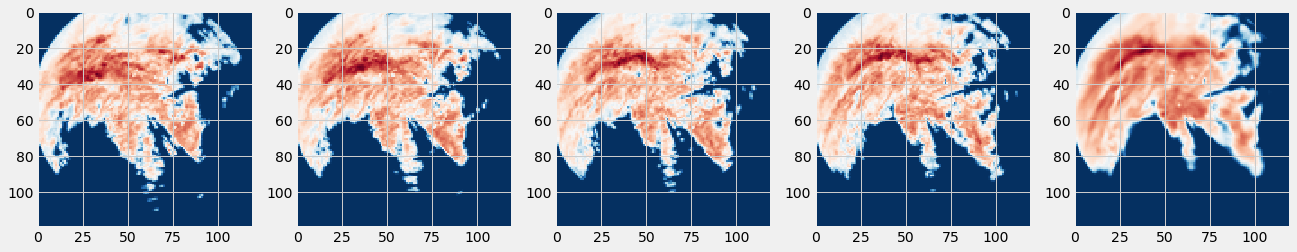

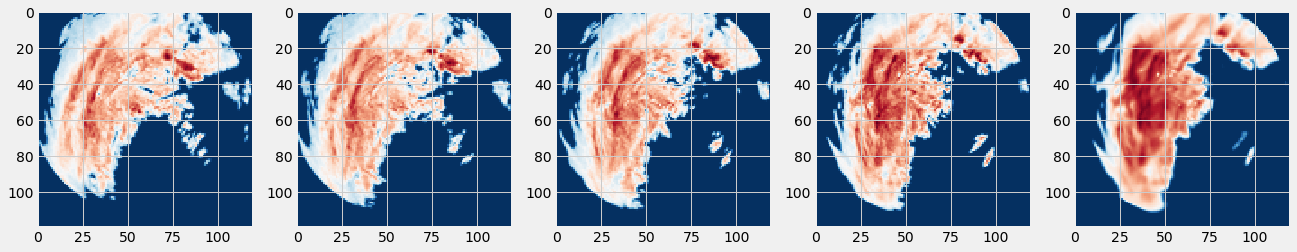

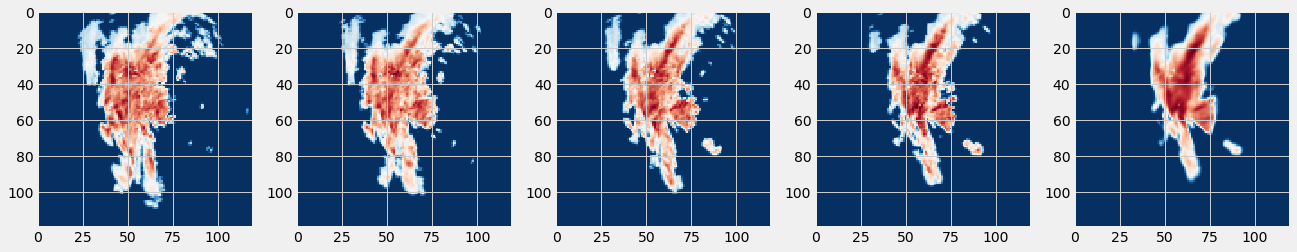

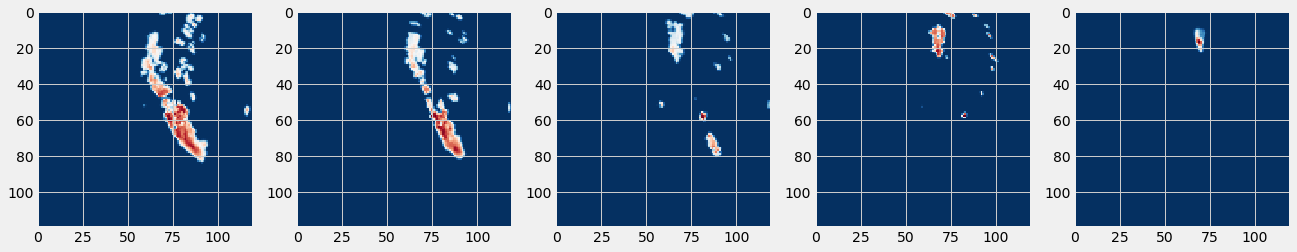

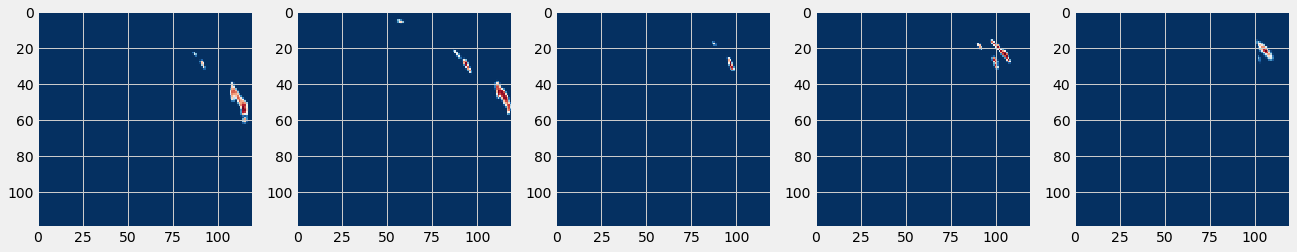

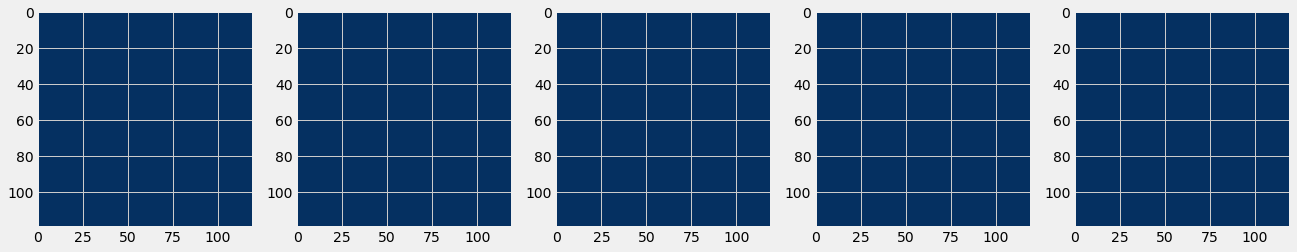

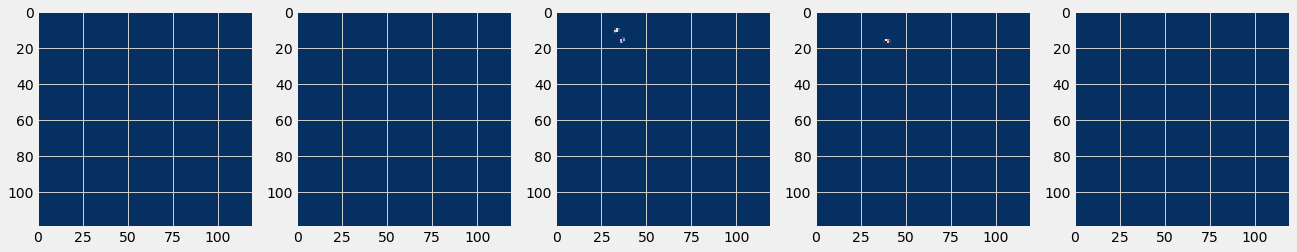

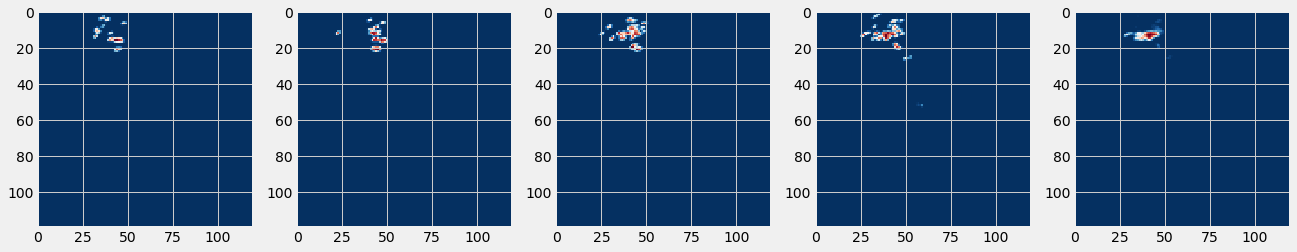

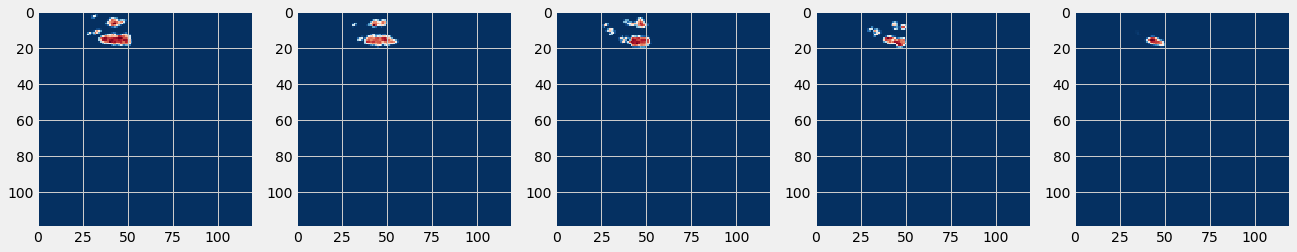

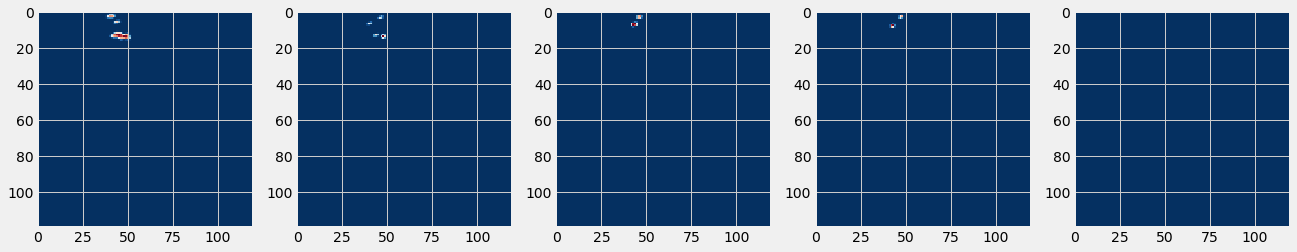

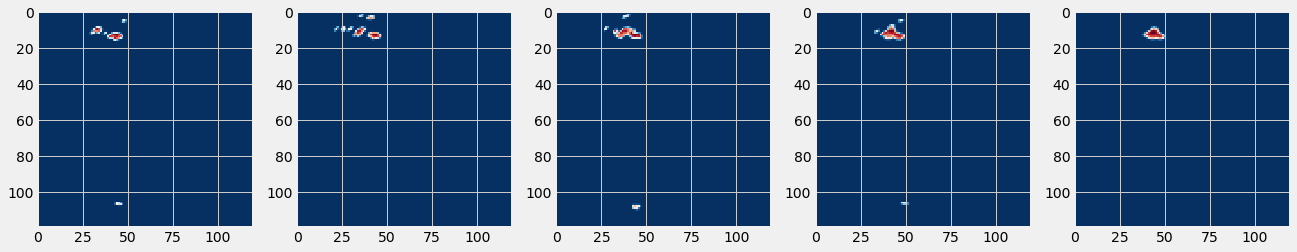

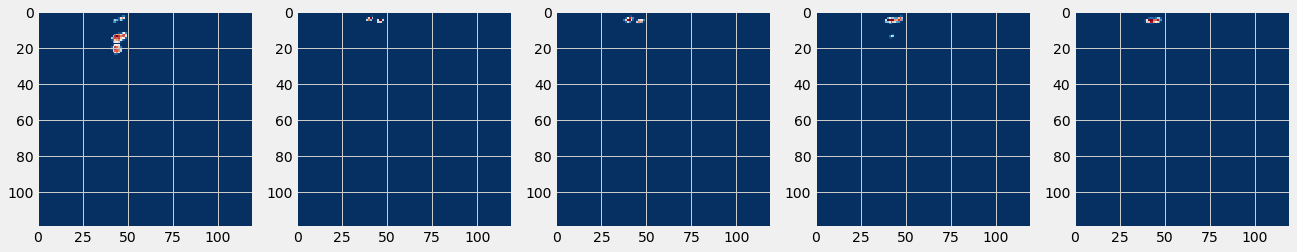

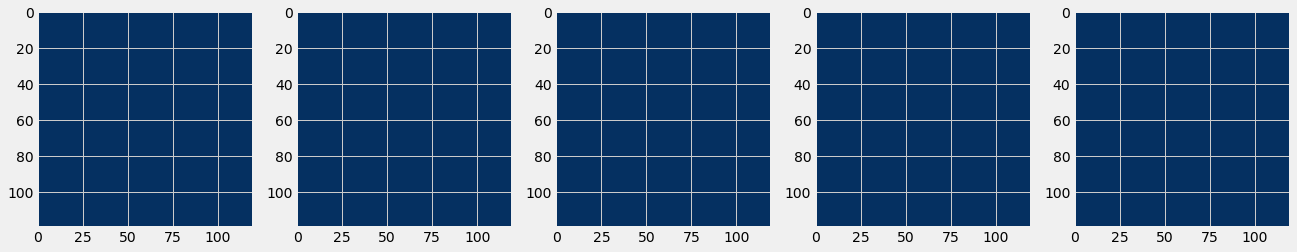

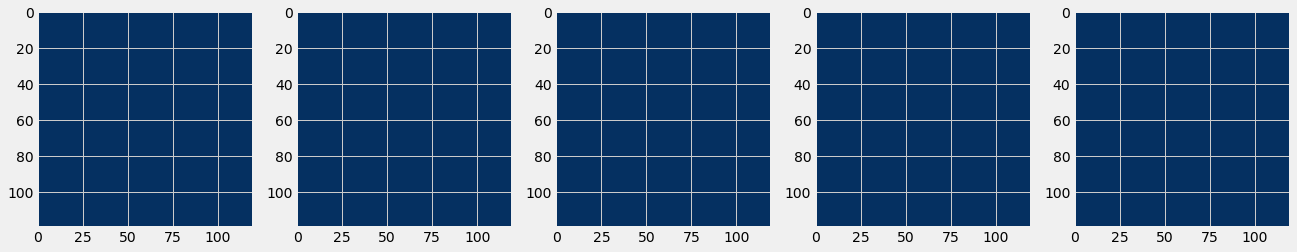

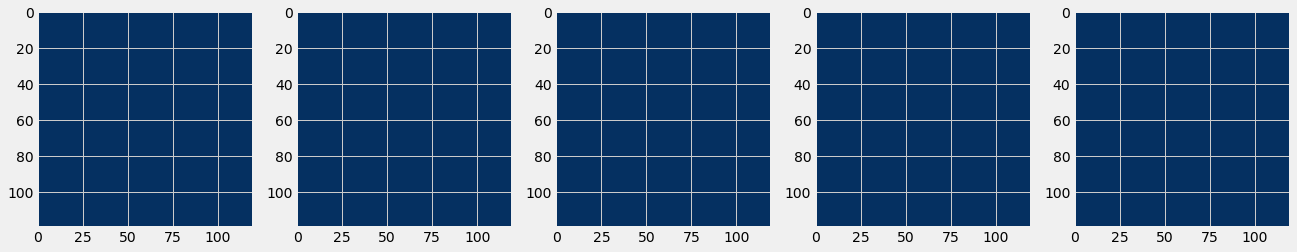

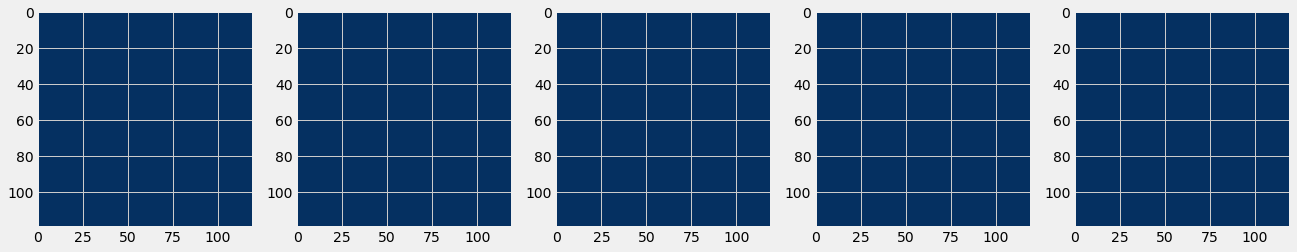

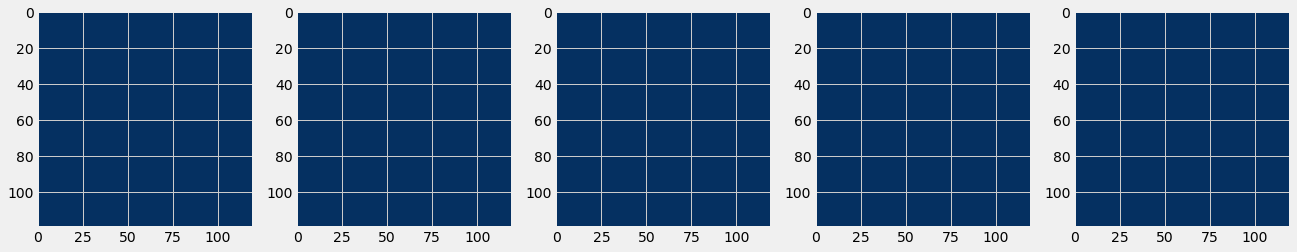

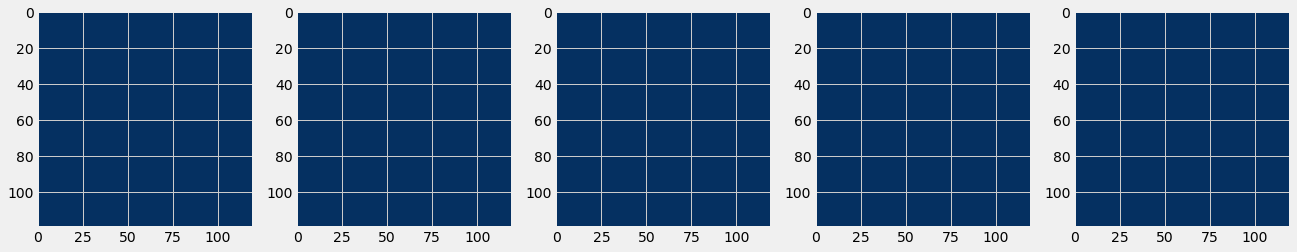

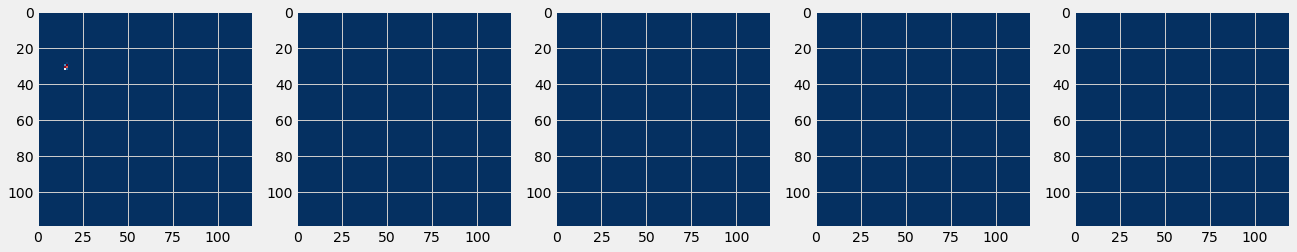

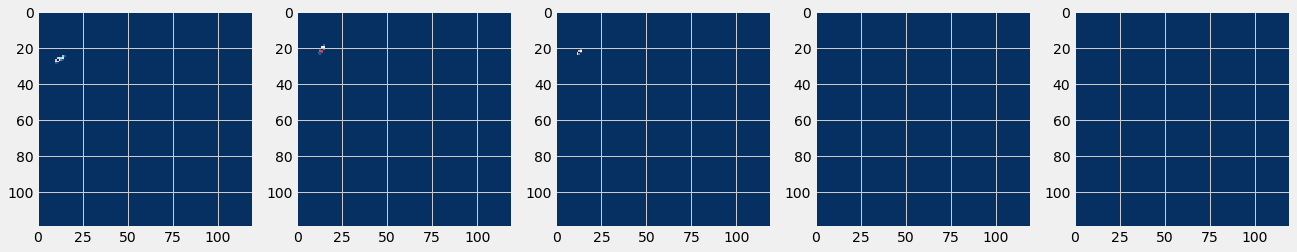

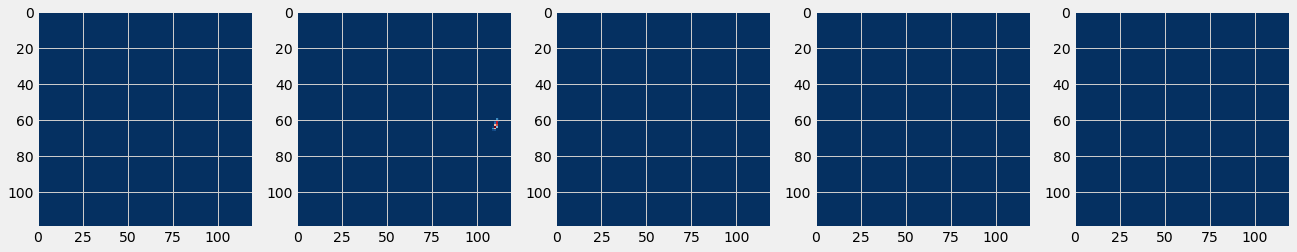

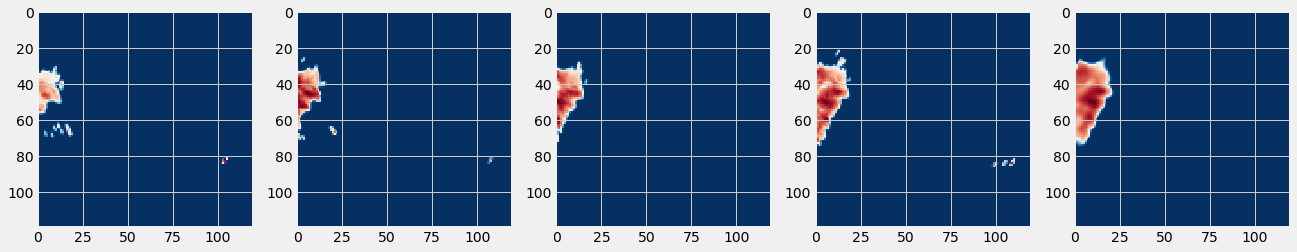

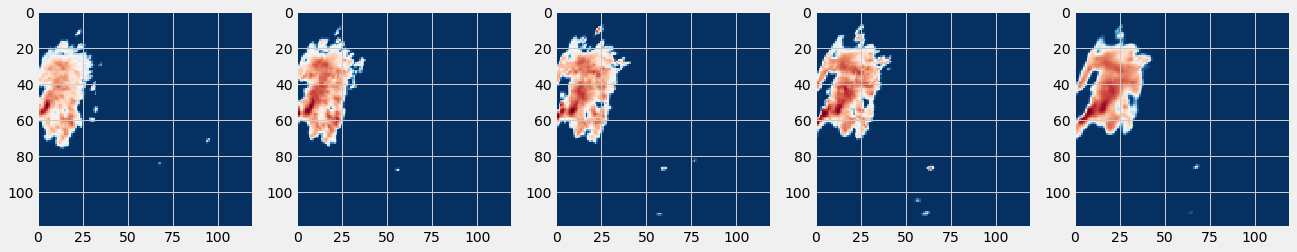

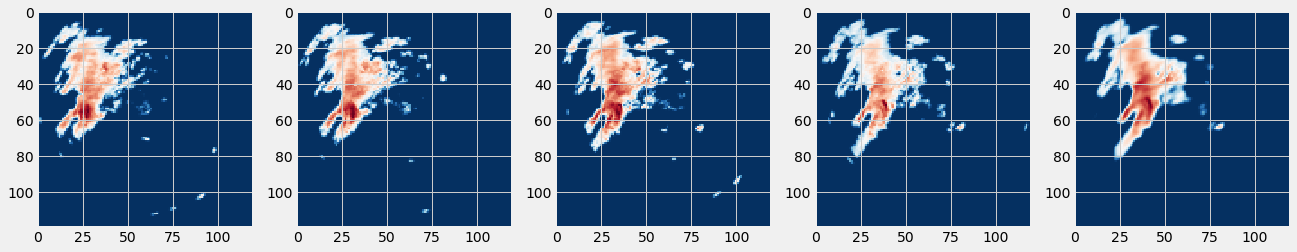

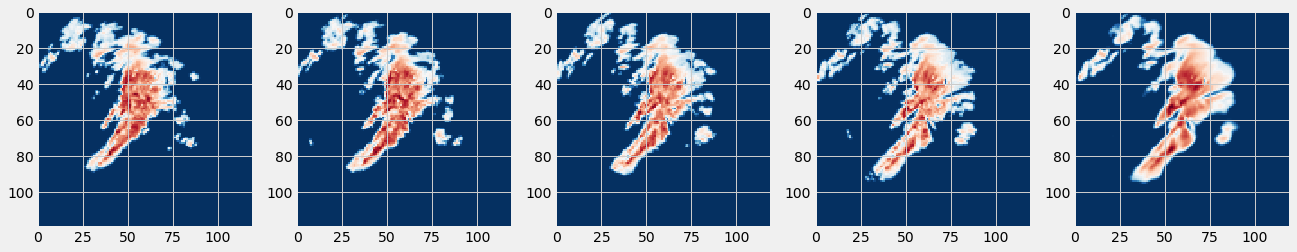

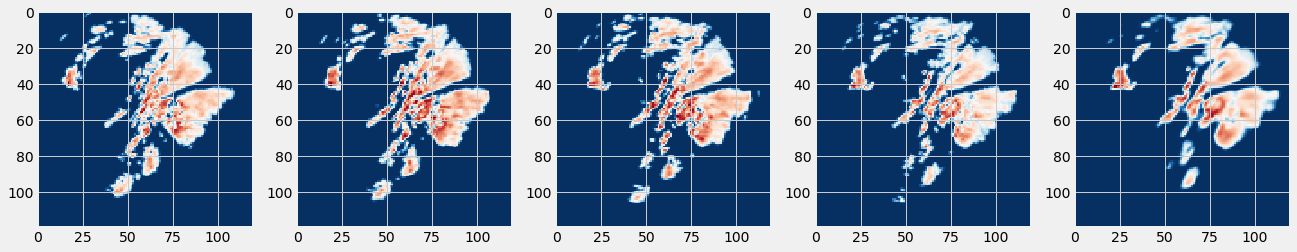

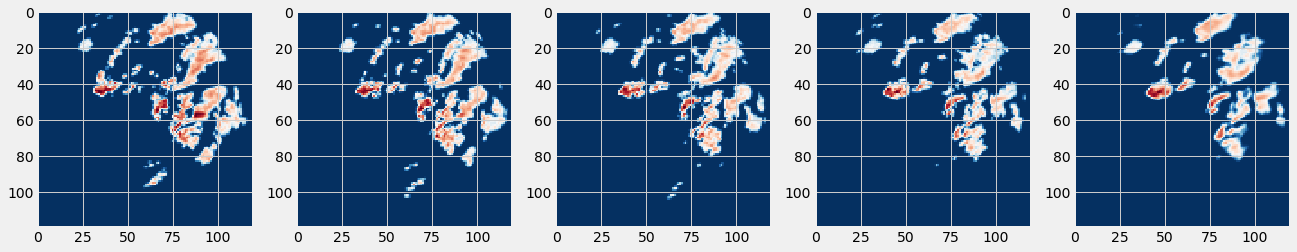

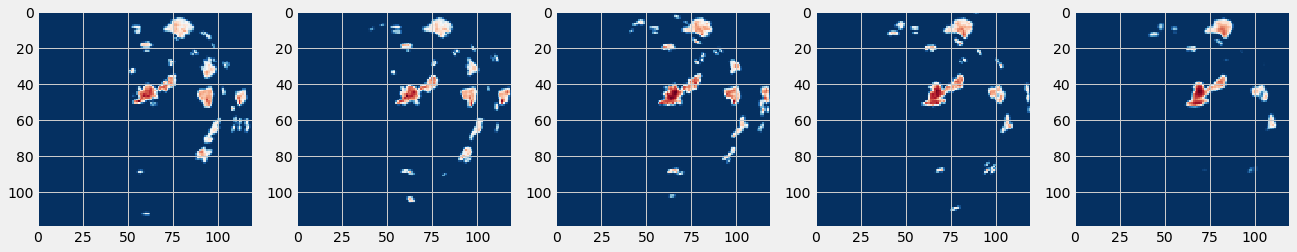

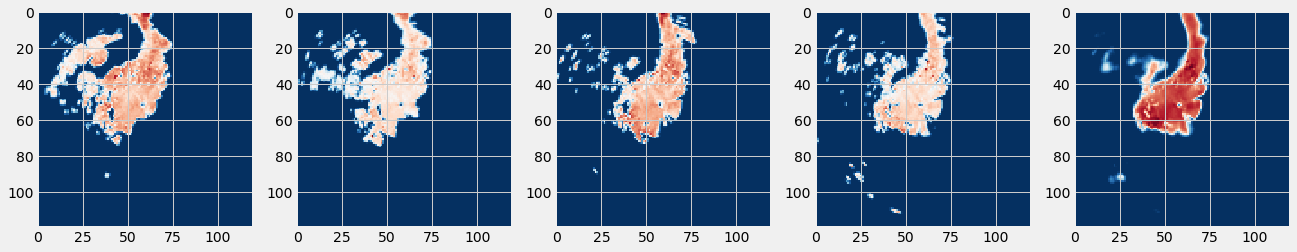

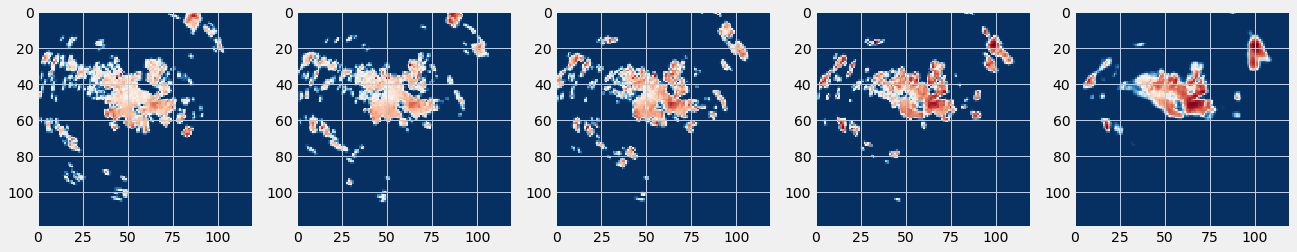

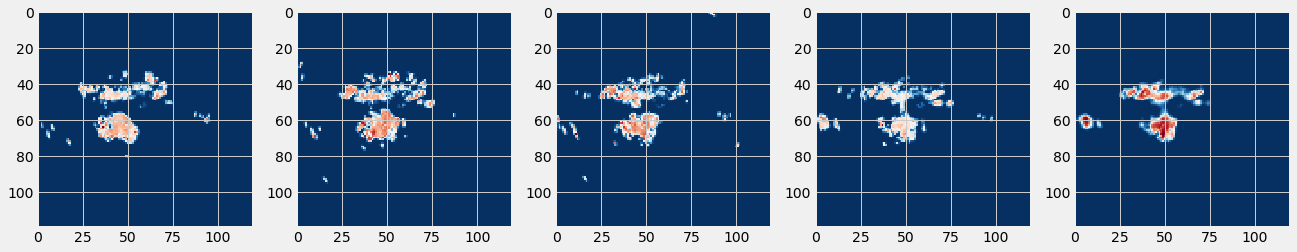

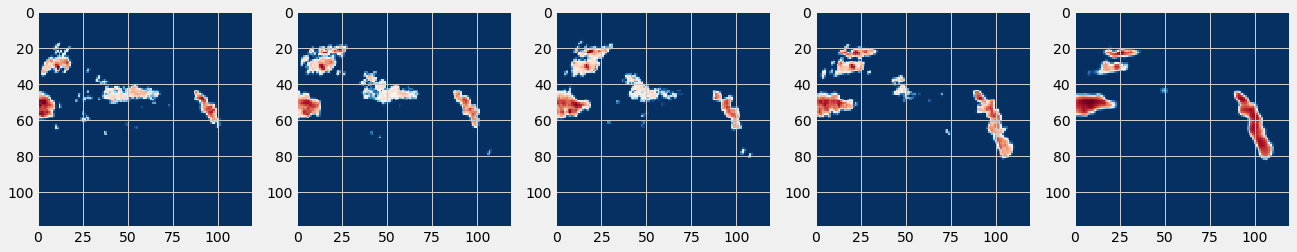

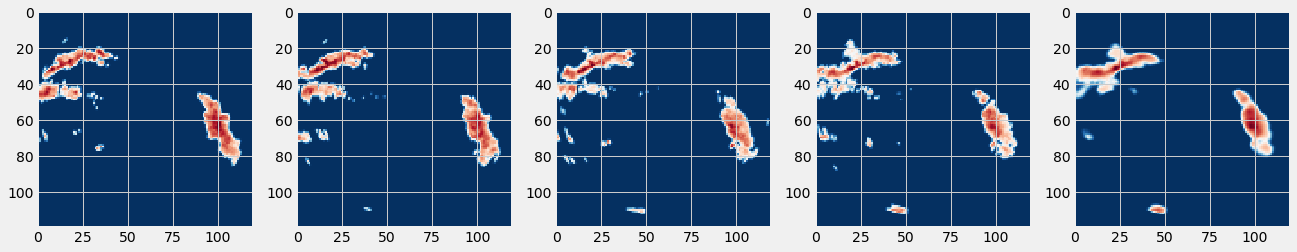

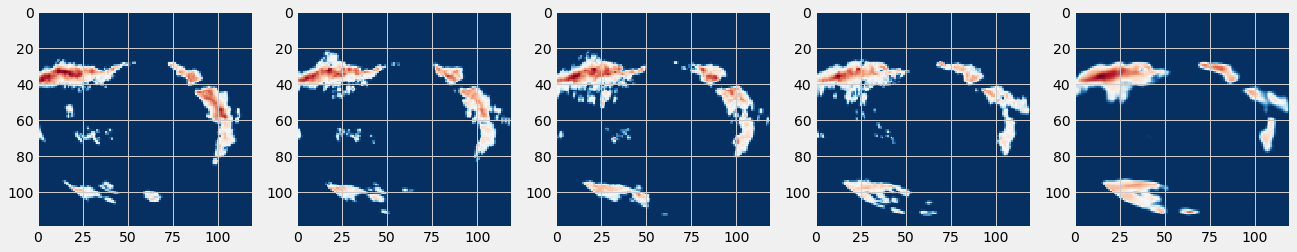

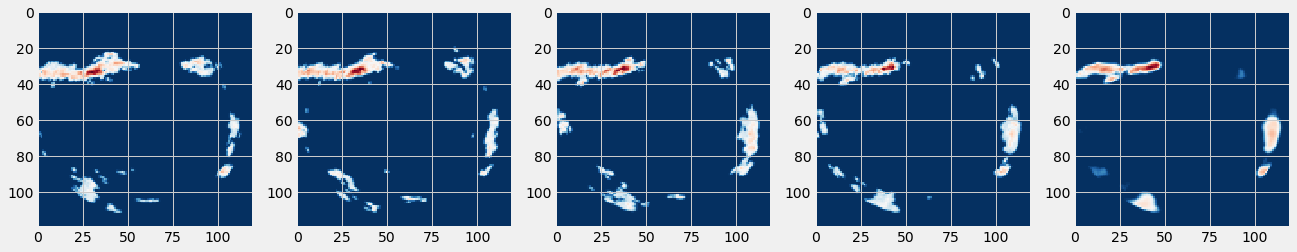

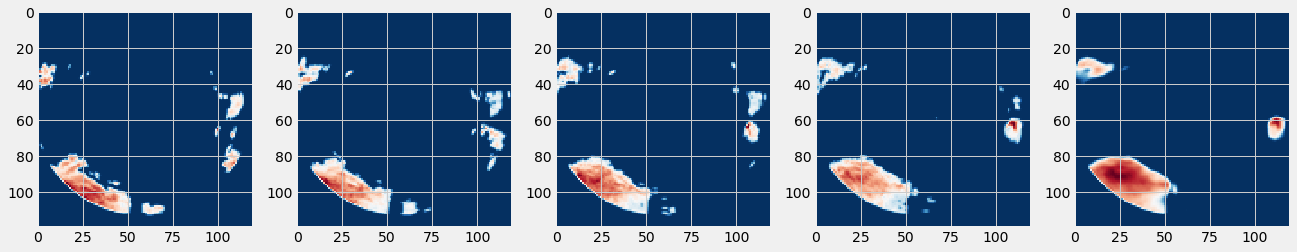

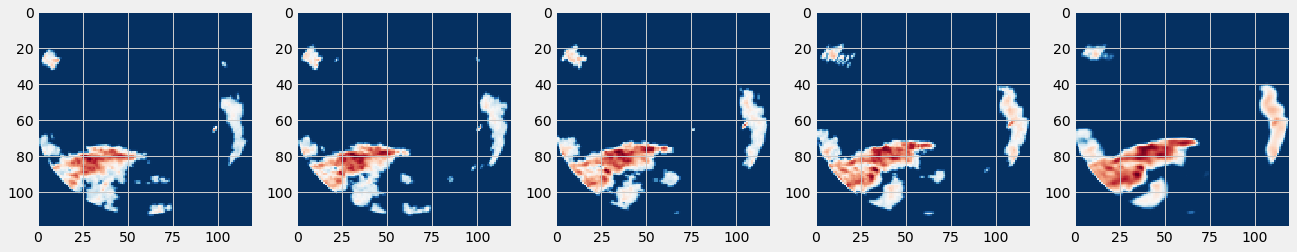

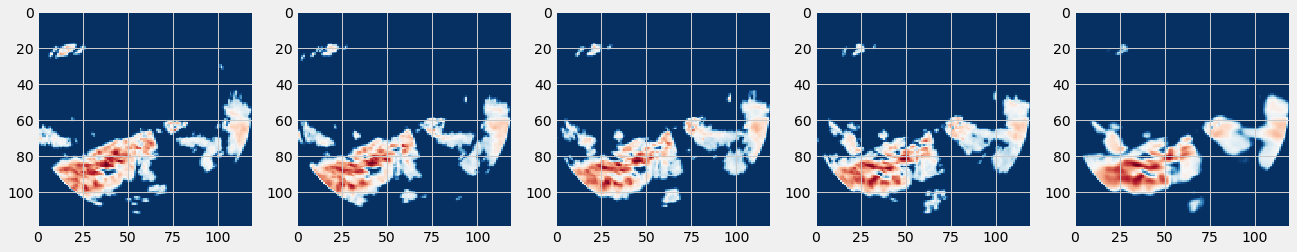

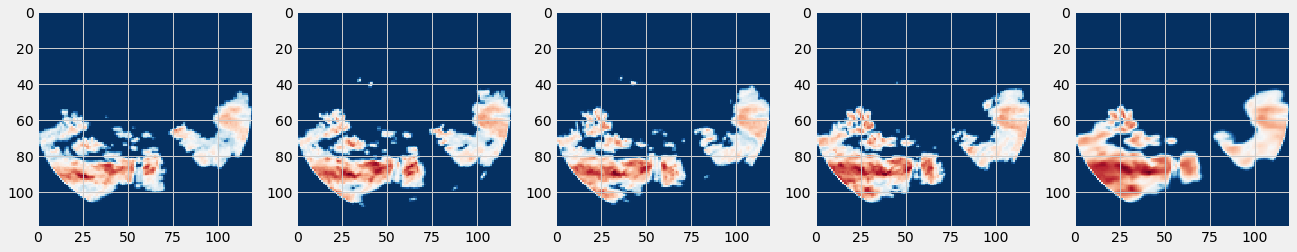

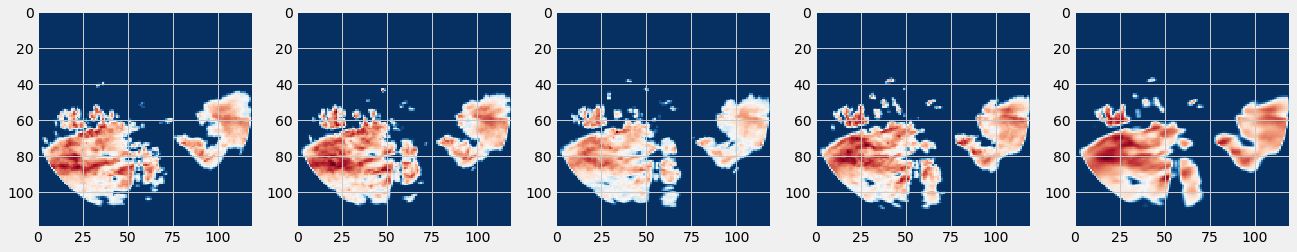

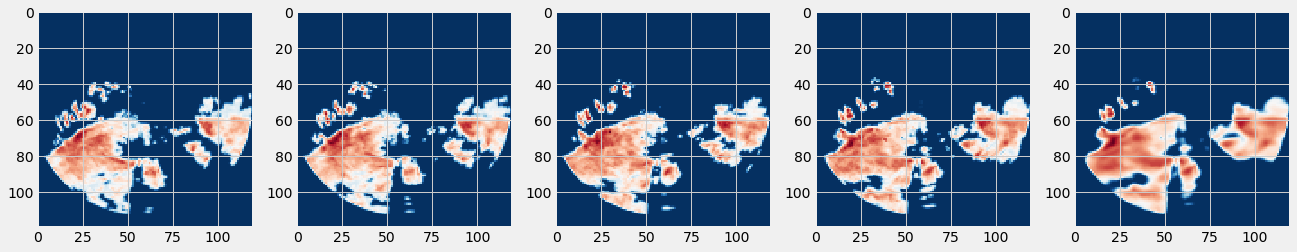

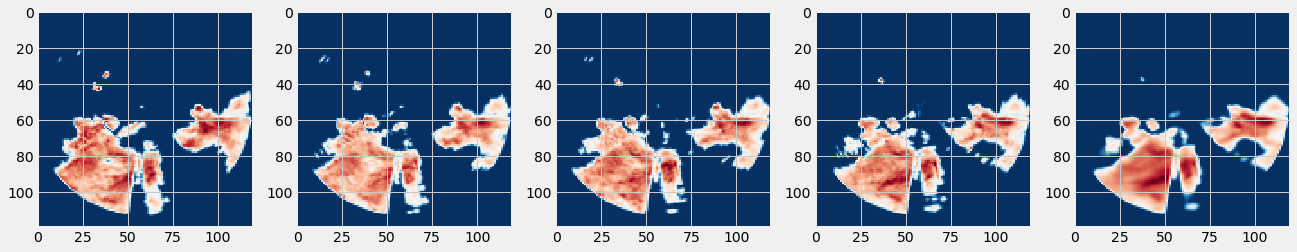

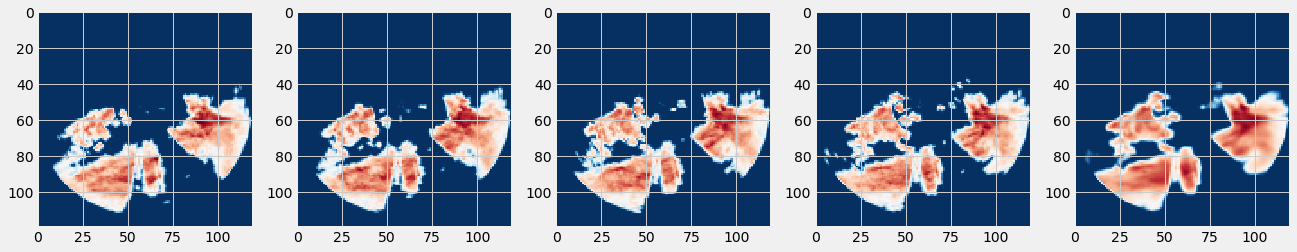

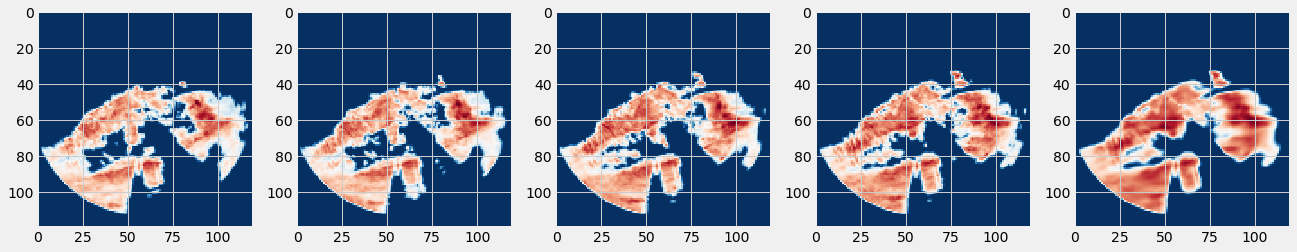

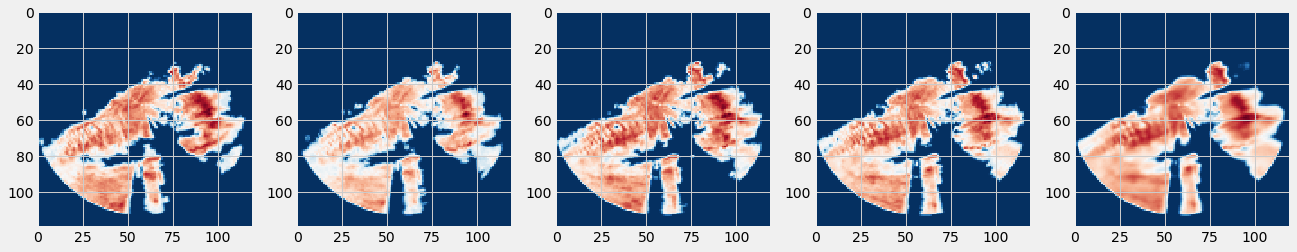

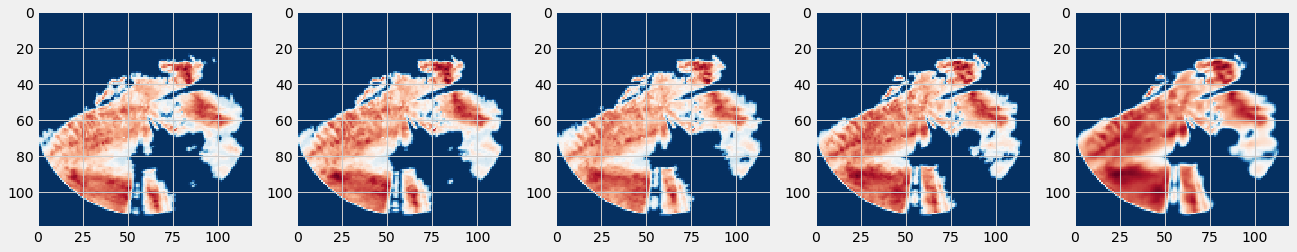

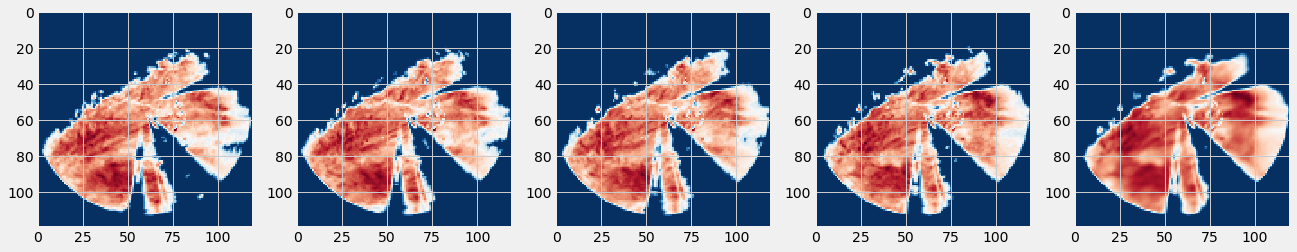

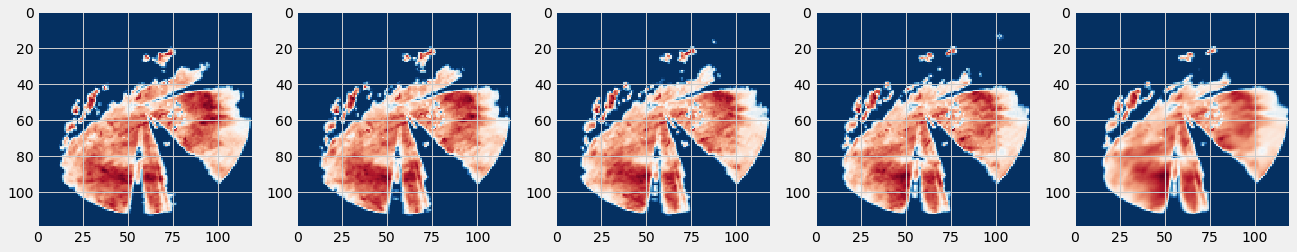

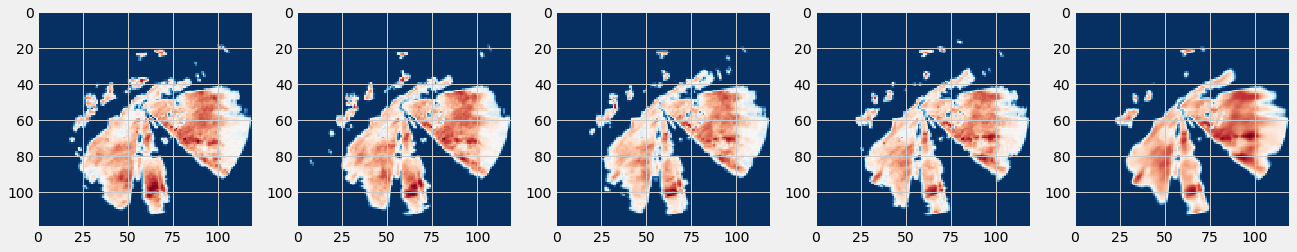

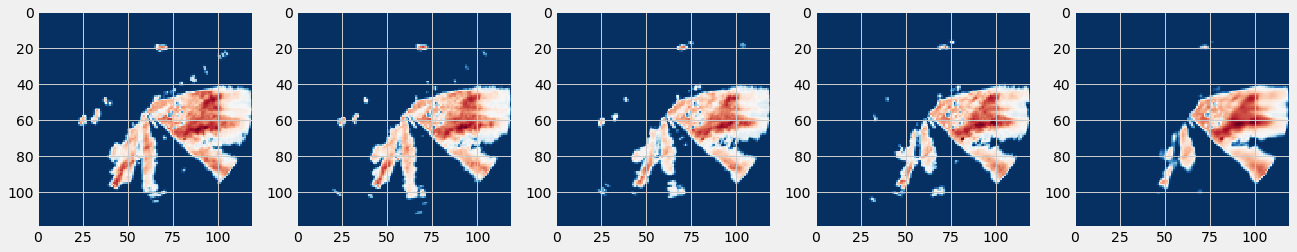

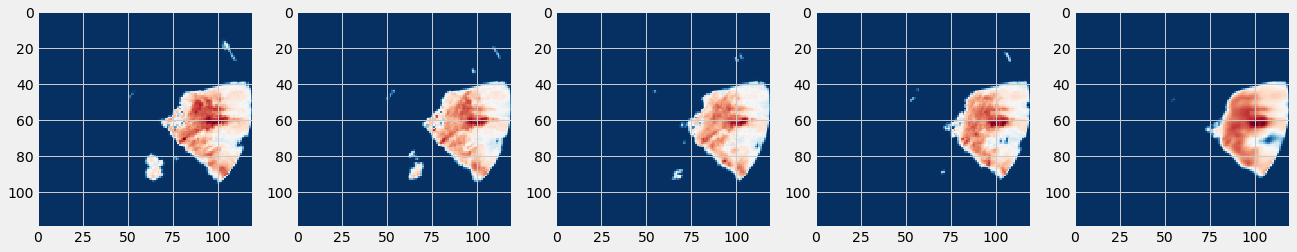

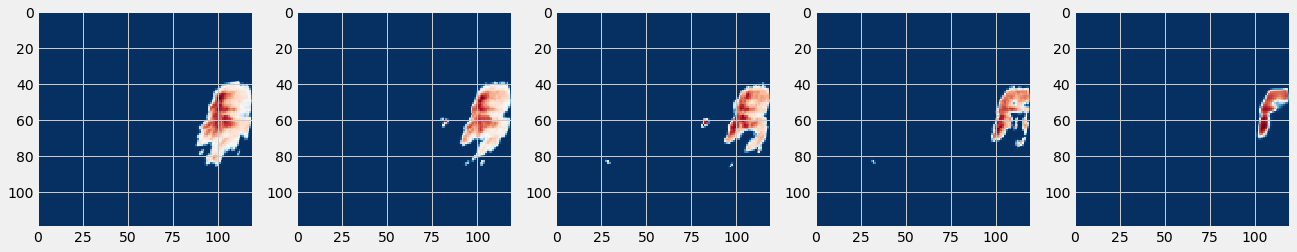

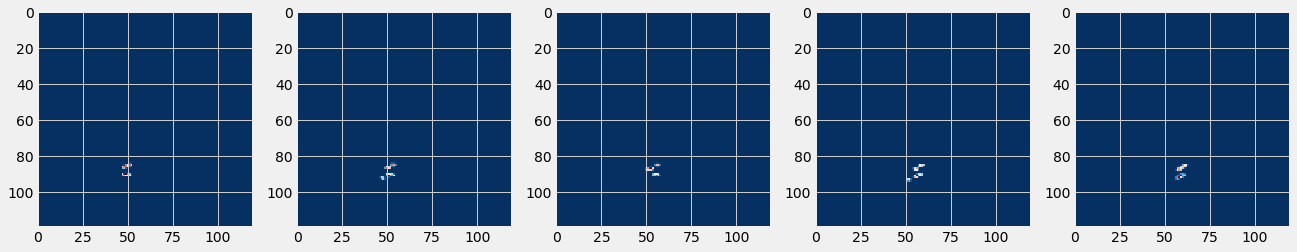

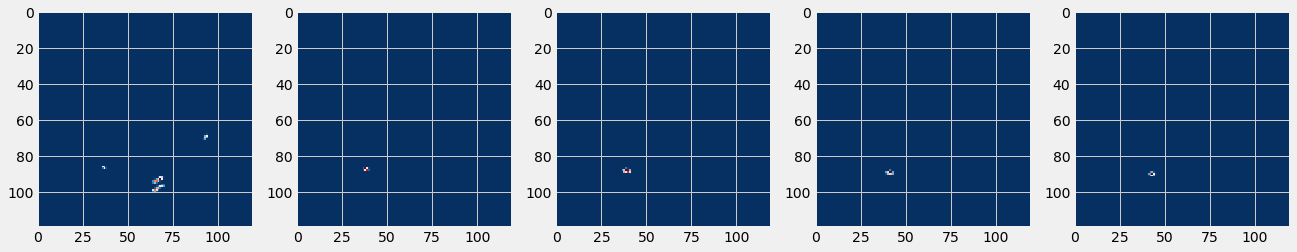

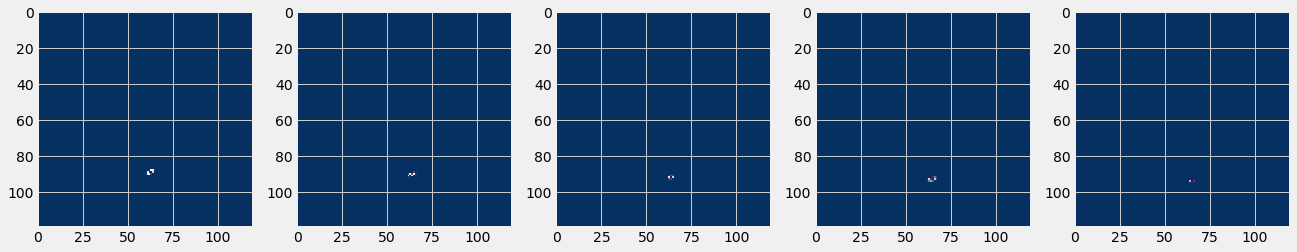

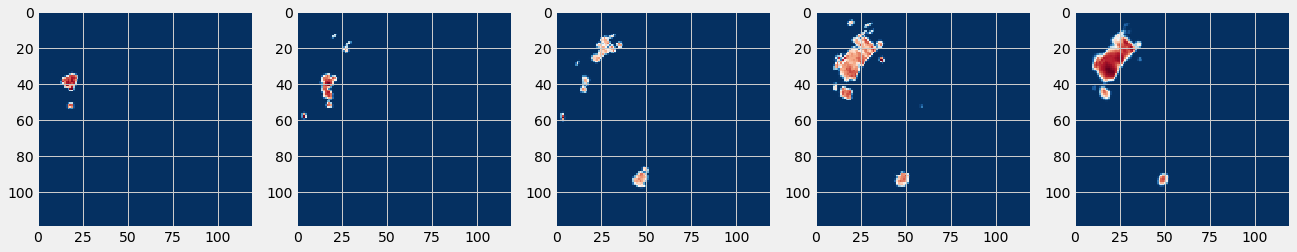

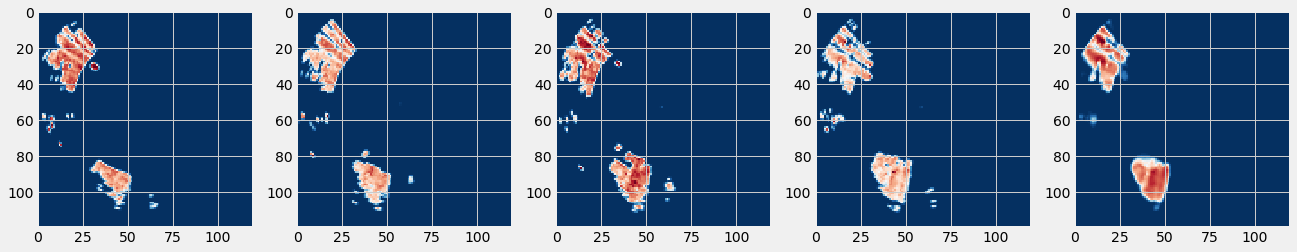

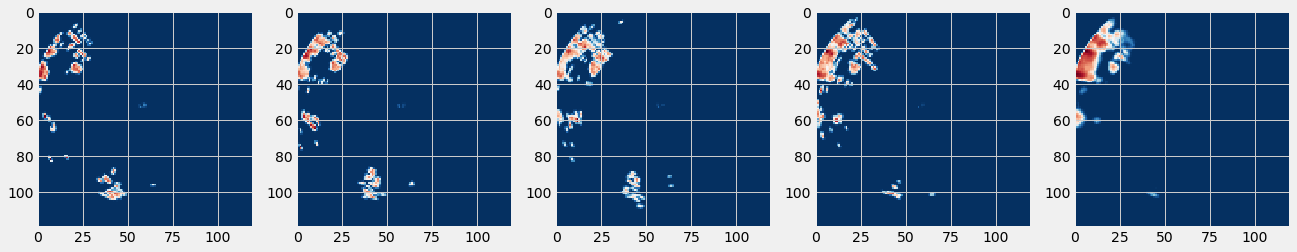

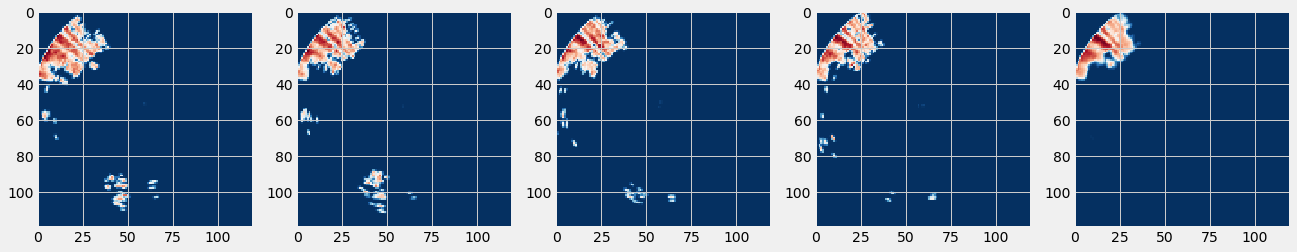

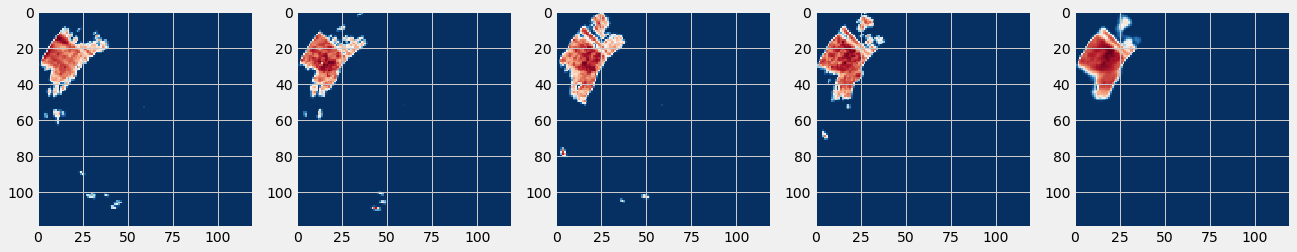

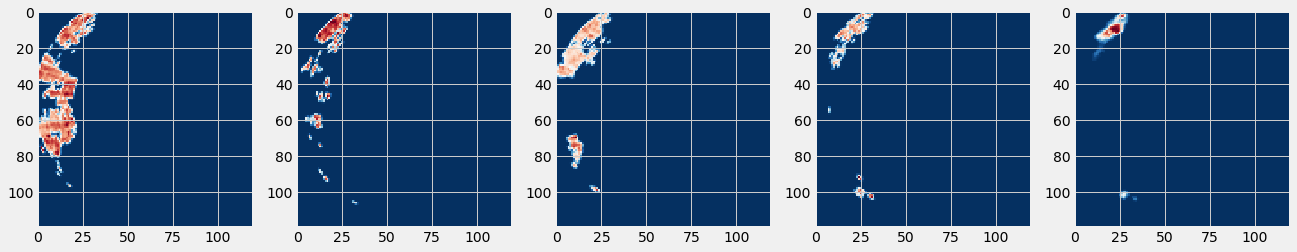

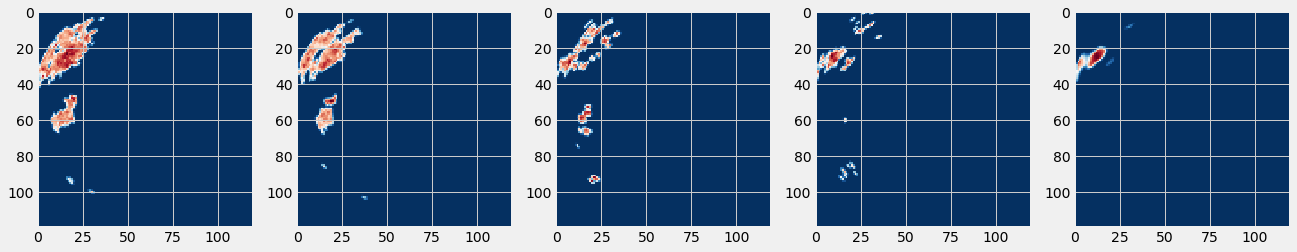

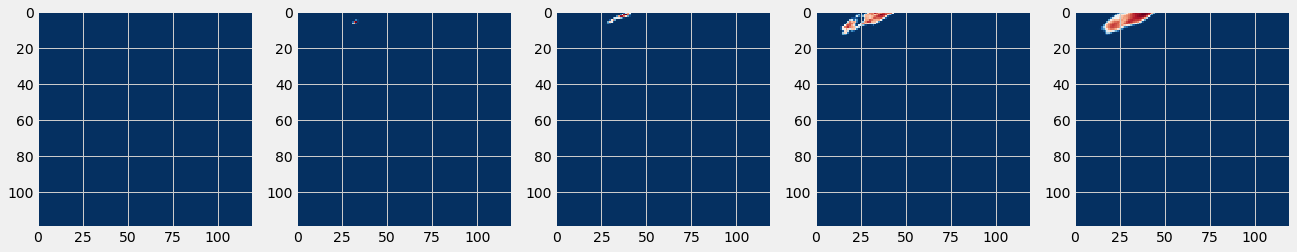

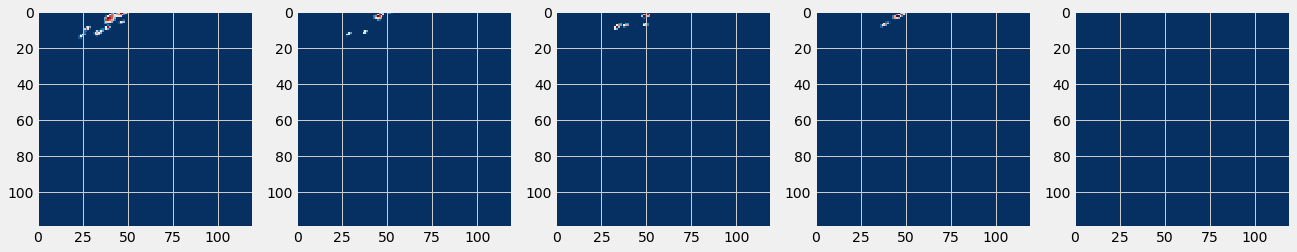

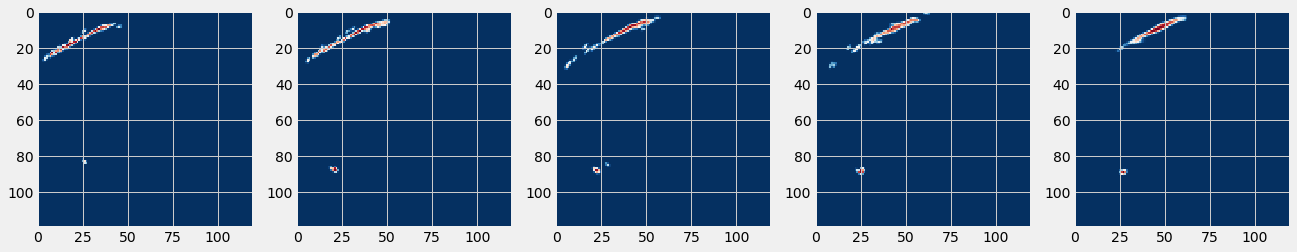

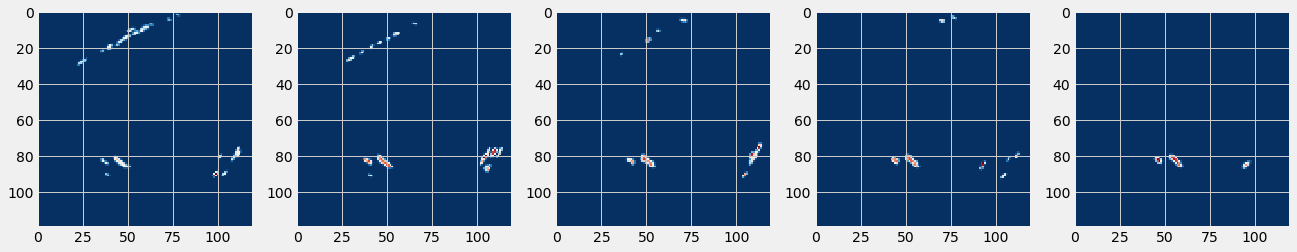

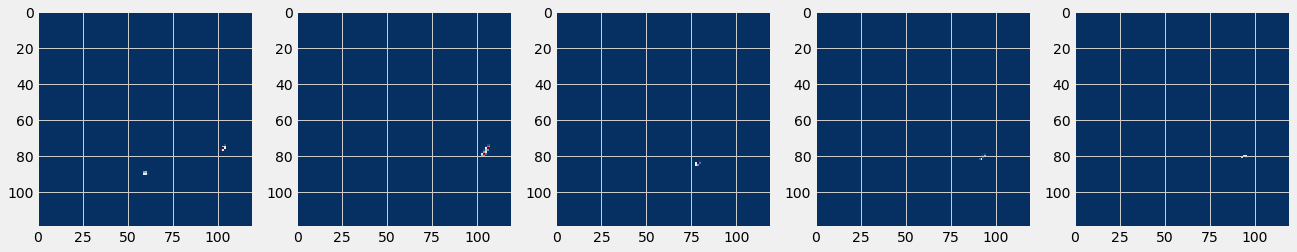

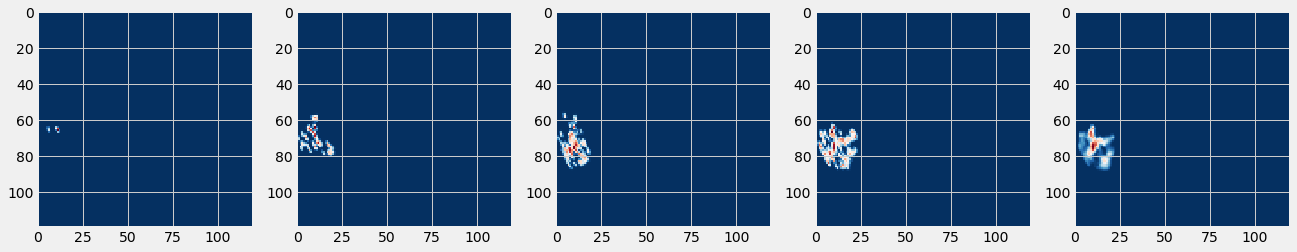

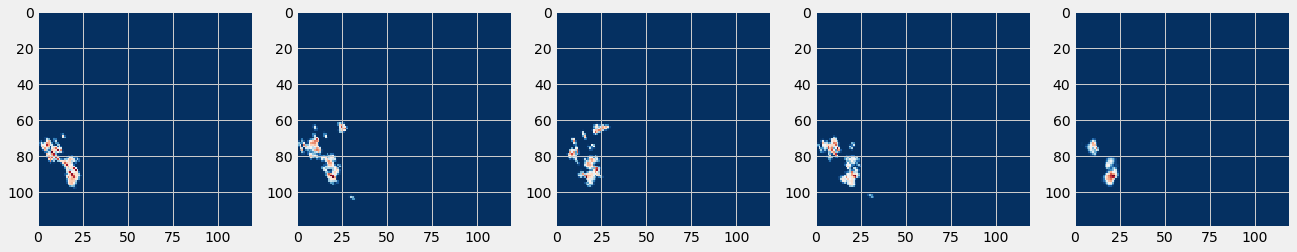

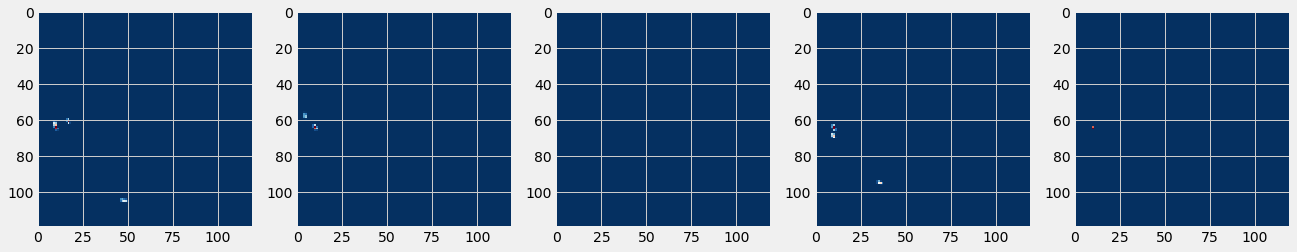

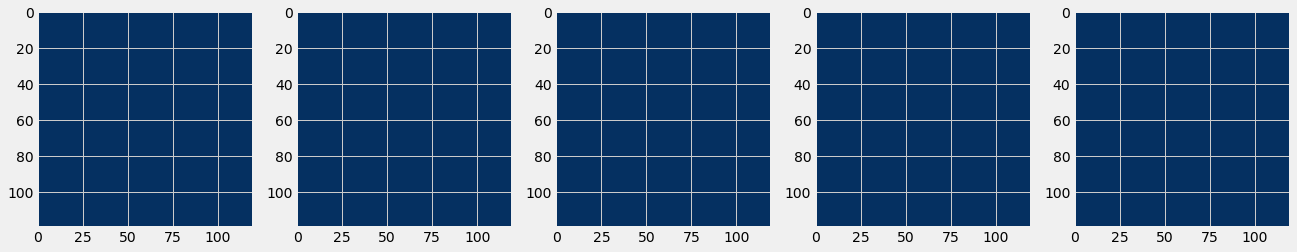

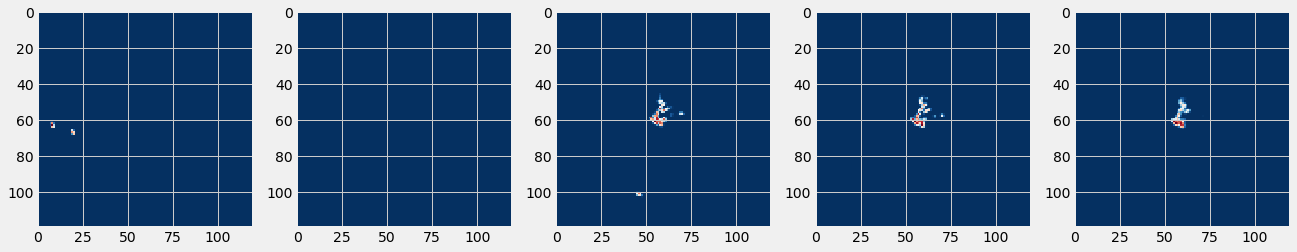

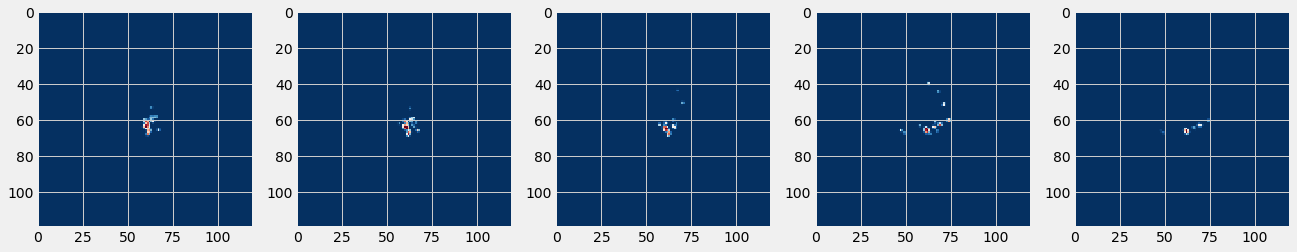

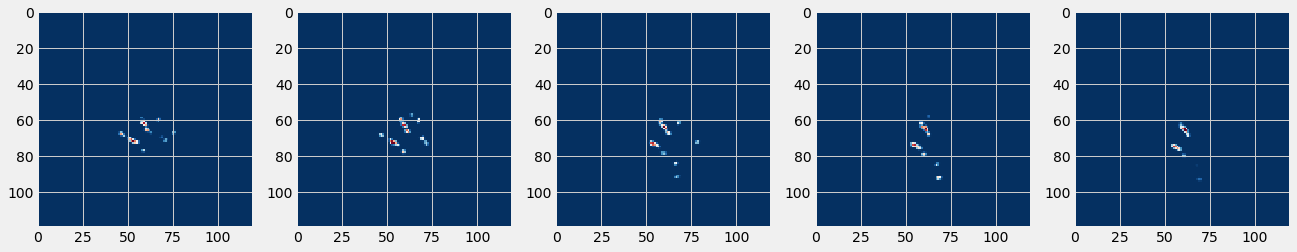

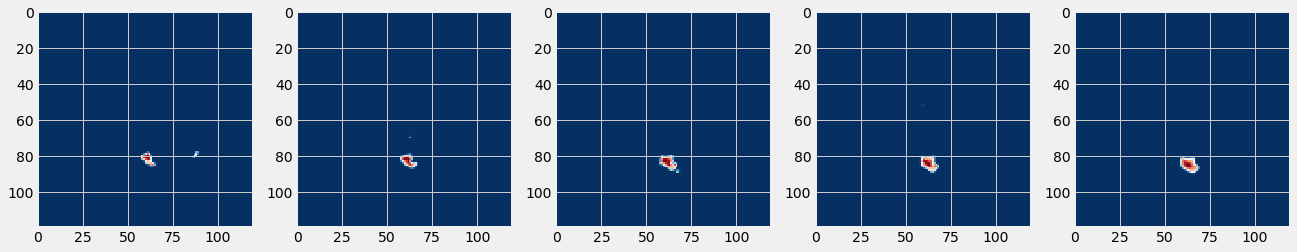

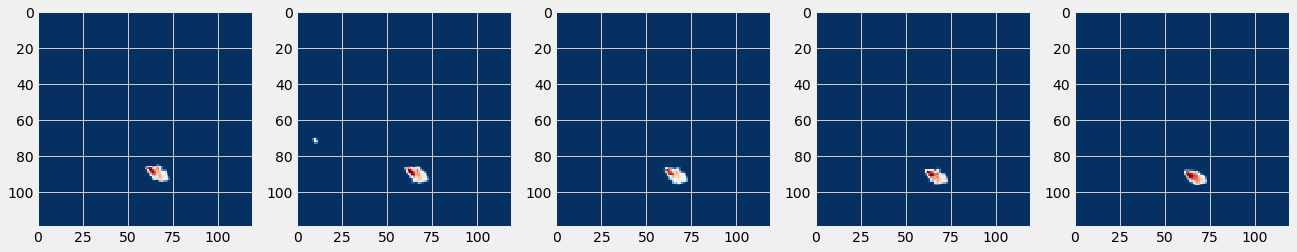

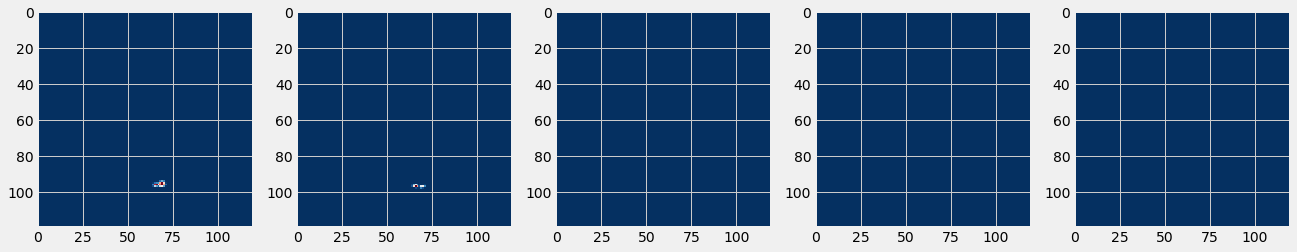

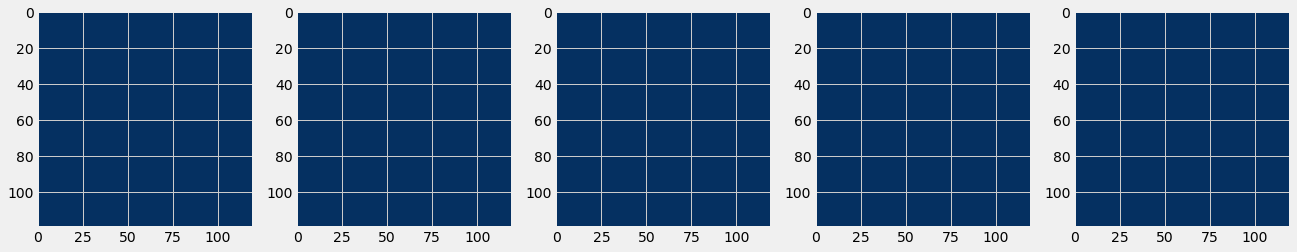

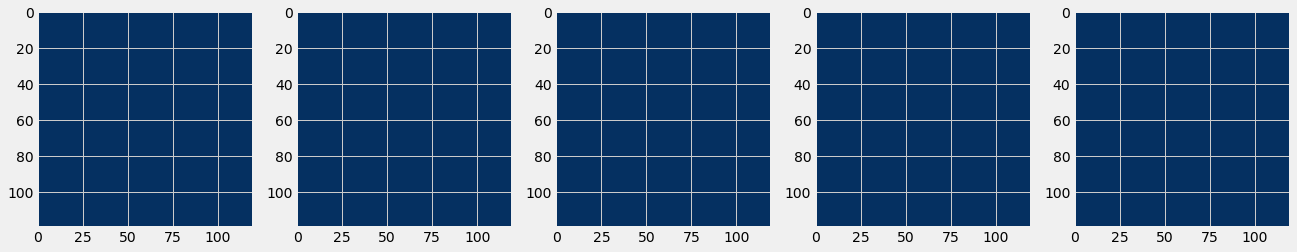

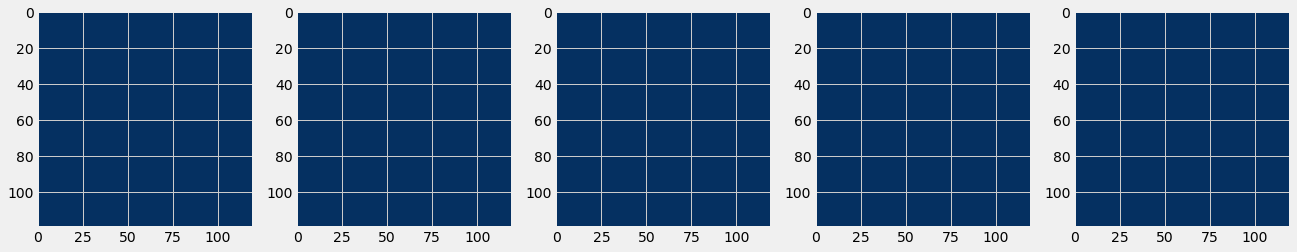

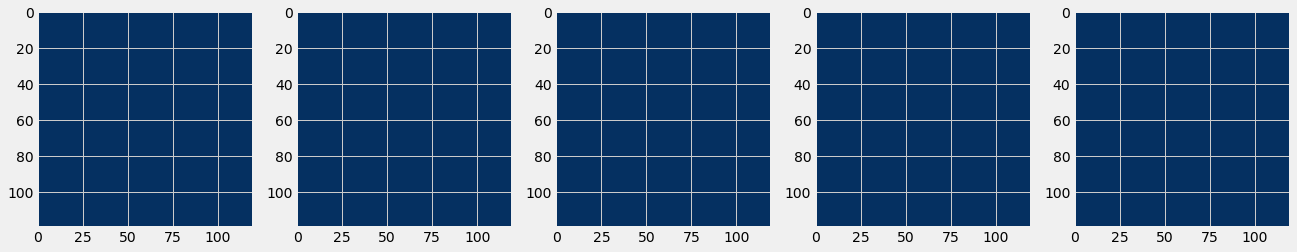

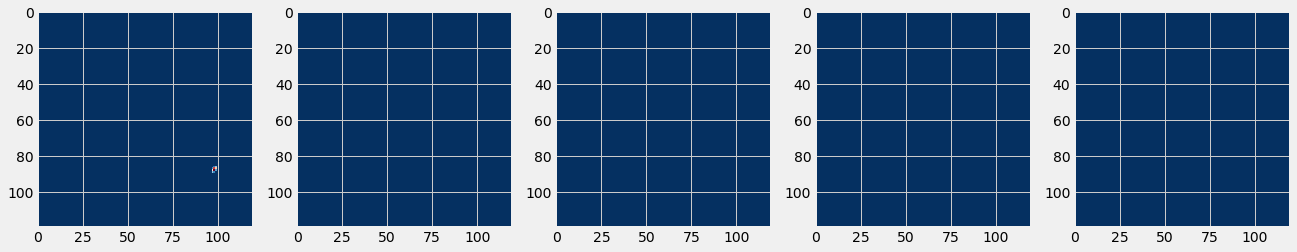

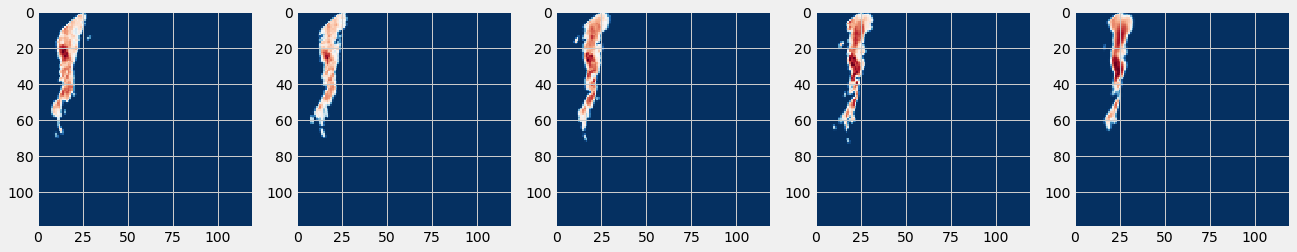

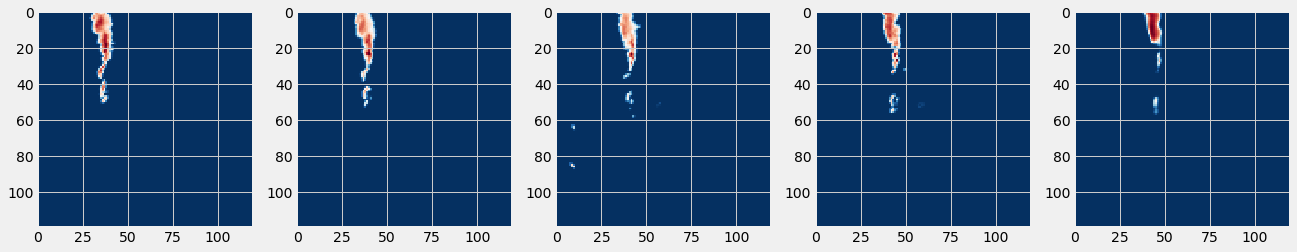

In [25]:
import matplotlib.pylab as plt
# (Submission 파일의 column index 값 : 6071, 6304, 7026, 7629, 7767, 8944, 11107)


color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

for img in range(200):
    image_sample = np.load(test_files[img]).flatten().reshape(120, 120, 4)

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20, 20))

    for i in range(4):
        plt.subplot(1,5,i+1)
        plt.imshow(image_sample[:, :, i], cmap=color_map)

    plt.subplot(1,5,5)
    plt.imshow(np.array(submission.iloc[img,1:].values.flatten().reshape(120, 120), dtype='uint8'), cmap = color_map)
    plt.show()

In [26]:
def torch_tta(x):
    preds = torch.rot90(best_model(torch.rot90(x, 1, [2, 3])), -1, [2, 3])
    preds += torch.rot90(best_model(torch.rot90(x, 2, [2, 3])), -2, [2, 3])
    preds += torch.rot90(best_model(torch.rot90(x, 3, [2, 3])), -3, [2, 3])
    preds += torch.flip(best_model(torch.flip(x, [2])), [2])
    preds += torch.flip(best_model(torch.flip(x, [3])), [3])
    preds += best_model(x)
    preds /= 6
    return preds

In [29]:
# TTA를 적용하는 정답지 
import gc
import time 
from tqdm.notebook import tqdm

total_preds = []
total_answer = []

test_preds = []
for fold, (tr_idx, val_idx) in tqdm(enumerate(kf.split(range(0, train_df.shape[0])))):
    val_file = train_df.loc[val_idx].reset_index(drop=True)
    
    valid_loader = DataLoader(CloudTrainDataset(data = val_file), batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
    test_loader = DataLoader(CloudTestDataset(data = test_df), batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

    best_model = UNet().cuda()
    best_model.load_state_dict(torch.load('./savedmodel/{}_FOLD_PYRAMID{}.pth'.format(model_name, fold)))
    
    best_model.eval()
    valid_pred = []
    valid_ans = []
    with torch.no_grad():
        for idx, (x_valid, y_valid) in enumerate(valid_loader):
            x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)               
            prediction = torch_tta(x_valid.cuda().float())
            valid_pred.append(prediction.cpu().numpy().reshape(-1,14400))
            valid_ans.append(y_valid.cpu().numpy().reshape(-1,14400))
        total_preds.append(valid_pred)
        total_answer.append(valid_ans)
            
    test_pred = []
    best_model.eval()
    with torch.no_grad():
        for idx, x_test in enumerate(test_loader):
            x_test = x_test.to(dev)             
            prediction = torch_tta(x_test.cuda().float())
            test_pred.append(prediction.cpu().numpy().reshape(-1,14400))
    test_preds.append(test_pred)

In [30]:
final_val = np.array(total_preds).reshape(-1, 14400)
final_answer = np.array(total_answer).reshape(-1, 14400)
loss(final_answer, final_val)

2.9431011993438005

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub.head()

In [ ]:
final_solution = np.reshape(np.mean(np.array(test_preds), axis=0), (-1, 14400))
final_solution = (final_solution * 255).astype(int)
submission = pd.concat([test_df, pd.DataFrame(final_solution)], axis=1)
submission.columns = np.append(['file_name'], [c for c in range(0, 14400)])
submission['file_name'] = sub['file_name'].values
submission.to_csv("cloud_v3(pyramid)(TTA).csv", index=False)